<a href="https://colab.research.google.com/github/ZeyuWu2001/The-Analysis-of-Police-Traffic-Stops-in-San-Francisco/blob/main/The_Analysis_of_Police_Traffic_Stops_in_San_Francisco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This part is for loading the file. The file is larger than 100 MB so we use google drive to store. Need to log in to a UC Berkeley account to access the folder.

#1 Load Data and Libraries

Data Source: https://openpolicing-stanford-edu.libproxy.berkeley.edu/data/

Reference: https://github.com/stanford-policylab/opp/tree/master

In [ ]:
!pip install --upgrade google-api-python-client osmnx transbigdata keplergl shap

In [ ]:
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
import io
import os

auth.authenticate_user()
drive_service = build('drive', 'v3')

folder_id = '10HKQjcAks19uggWfRFeeoOnQgCXcqV6E' # the folder that I put all files
query = f"'{folder_id}' in parents and trashed=false"
results = drive_service.files().list(q=query, fields="nextPageToken, files(id, name)").execute()
items = results.get('files', [])

In [ ]:
save_path = '/content/folder_files'
if not os.path.exists(save_path):
    os.makedirs(save_path)

if items:
    for item in items:
        print(f"downloading: {item['name']}")

        # download
        file_id = item['id']
        request = drive_service.files().get_media(fileId=file_id)
        file_data = io.BytesIO()
        downloader = MediaIoBaseDownload(file_data, request)

        done = False
        while done is False:
            status, done = downloader.next_chunk()

        # save the files in colab
        file_data.seek(0)
        file_path = os.path.join(save_path, item['name'])
        with open(file_path, 'wb') as f:
            f.write(file_data.read())
        print(f"{item['name']} saved in {file_path}")

downloading: ca_san_francisco_2020_04_01.csv
ca_san_francisco_2020_04_01.csv saved in /content/folder_files/ca_san_francisco_2020_04_01.csv


In [ ]:
%cd /content/folder_files

/content/folder_files


In [ ]:
# Load dictionaries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay

# Others
from sklearn.decomposition import PCA

import geopandas as gpd
import folium
from folium.plugins import HeatMap
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("ca_san_francisco_2020_04_01.csv")
df.head()

<ipython-input-20-24b9f68070c4>:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("ca_san_francisco_2020_04_01.csv")


raw_row_number        date      time                   location        lat  \
0         869921  2014-08-01  00:01:00       MASONIC AV & FELL ST  37.773004   
1         869922  2014-08-01  00:01:00              GEARY&10TH AV  37.780898   
2         869923  2014-08-01  00:15:00        SUTTER N OCTAVIA ST  37.786919   
3         869924  2014-08-01  00:18:00          3RD ST & DAVIDSON  37.746380   
4         869925  2014-08-01  00:19:00  DIVISADERO ST. & BUSH ST.  37.786348   

          lng district  subject_age            subject_race subject_sex  ...  \
0 -122.445873      NaN          NaN  asian/pacific islander      female  ...   
1 -122.468586      NaN          NaN                   black        male  ...   
2 -122.426718      NaN          NaN                hispanic        male  ...   
3 -122.392005      NaN          NaN                hispanic        male  ...   
4 -122.440003      NaN          NaN                   white        male  ...   

  citation_issued  warning_issued   outcome  contraband_found  \
0           False            True   warning               NaN   
1            True           False  citation               NaN   
2            True           False  citation               NaN   
3           False            True   warning               NaN   
4            True           False  citation               NaN   

  search_conducted search_vehicle  search_basis  \
0            False          False           NaN   
1            False          False           NaN   
2            False          False           NaN   
3            False          False           NaN   
4            False          False           NaN   

                             reason_for_stop raw_search_vehicle_description  \
0  Mechanical or Non-Moving Violation (V.C.)                      No Search   
1  Mechanical or Non-Moving Violation (V.C.)                      No Search   
2  Mechanical or Non-Moving Violation (V.C.)                      No Search   
3  Mechanical or Non-Moving Violation (V.C.)                      No Search   
4  Mechanical or Non-Moving Violation (V.C.)                      No Search   

  raw_result_of_contact_description  
0                           Warning  
1                          Citation  
2                          Citation  
3                           Warning  
4                          Citation  

[5 rows x 22 columns]

#2 Data cleaning and feature engineering

Define a function to describe the data

In [ ]:
def describe_dataframe(df):
    summary = {}
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:  # For numeric variables
            summary[col] = {
                'count': df[col].count(),
                'mean': df[col].mean(),
                'std': df[col].std(),
                'min': df[col].min(),
                '25%': df[col].quantile(0.25),
                '50% (median)': df[col].median(),
                '75%': df[col].quantile(0.75),
                'max': df[col].max()
            }
        else:  # For others
            summary[col] = df[col].value_counts().to_dict()
    return summary

Take a look at the original data, lots of NaNs and messy

In [ ]:
# find nan
nan_counts = df.isna().sum()
print("NaN summary\n", nan_counts)
# describe_dataframe(df)  # It's messy to run this here

NaN summary
 raw_row_number                            0
date                                      0
time                                     35
location                                 43
lat                                    1697
lng                                    1697
district                              52187
subject_age                           58888
subject_race                              0
subject_sex                               0
type                                      0
arrest_made                               0
citation_issued                           0
warning_issued                            0
outcome                               15681
contraband_found                     851689
search_conducted                          0
search_vehicle                            0
search_basis                         851689
reason_for_stop                        2212
raw_search_vehicle_description            0
raw_result_of_contact_description         0
dtype: int64


Clean up the data as follows (the warning doesn't influence the result)

In [ ]:
# drop repeat or not-interpretable columns
df_clean = df.drop(columns = ["raw_row_number", "location", "lat", "lng", "arrest_made", "citation_issued", "warning_issued", "search_basis", 'type','raw_result_of_contact_description','raw_search_vehicle_description'])

# drop those missing time or age as those are important features we are going to model on
df_clean = df_clean[~((df_clean["time"].isna()) | (df_clean["subject_age"].isna()))]

# Get year and month from data; get hour from time, and drop original columns
df_clean['year'] = pd.to_datetime(df_clean['date'], format='%Y-%m-%d').dt.year.astype(object)
df_clean['month'] = pd.to_datetime(df_clean['date'], format='%Y-%m-%d').dt.month.astype(object)
df_clean['hour'] = pd.to_datetime(df_clean['time'], format='%H:%M:%S').dt.hour.astype(object)
df_clean = df_clean.drop(columns=['date', 'time'])

# According to definition, update NaNs in contraband_found according to search_conducted
df_clean['contraband_found'] = df_clean.apply(
    lambda row: "no_search" if pd.isna(row['contraband_found']) and row['search_conducted'] == False else row['contraband_found'],
    axis=1
)
# delete this since contraband_found already covers the info
df_clean = df_clean.drop(columns = ['search_conducted', "search_vehicle"])

# For columns reason_for_stop, messy categories has below 200 instances. So we merge them into Other
reason_counts = df_clean['reason_for_stop'].value_counts()
df_clean['reason_for_stop'] = df_clean['reason_for_stop'].replace(reason_counts[reason_counts <= 200].index, "Other")

# change NaN in outcome to no_action
df_clean['outcome'] = df_clean['outcome'].fillna('no_action')

# change NaN in district to no_record
df_clean['district'] = df_clean['district'].fillna('no_record')

# change NaN in reason_for_stop to no_record
df_clean['reason_for_stop'] = df_clean['reason_for_stop'].fillna('no_record')

df_clean.head()

district  subject_age            subject_race subject_sex   outcome  \
33159        C         56.0                   white        male  citation   
33160        B         32.0                   white        male  citation   
33161        I         57.0  asian/pacific islander      female  citation   
33162        A         31.0                hispanic        male   warning   
33163        J         37.0                hispanic      female  citation   

      contraband_found                            reason_for_stop  year month  \
33159        no_search  Mechanical or Non-Moving Violation (V.C.)  2007     1   
33160        no_search                           Moving Violation  2007     1   
33161        no_search                           Moving Violation  2007     1   
33162        no_search                           Moving Violation  2007     1   
33163        no_search                           Moving Violation  2007     1   

      hour  
33159   10  
33160   10  
33161   10  
33162   10  
33163   10

Below shows that the data is quite clean.

In [ ]:
nan_counts_clean = df_clean.isna().sum()
print(nan_counts_clean)
# describe_dataframe(df_clean)

district            0
subject_age         0
subject_race        0
subject_sex         0
outcome             0
contraband_found    0
reason_for_stop     0
year                0
month               0
hour                0
dtype: int64


# 3 Exploratory Data Analysis

## Plot some images

In [ ]:
outcome_order = ["arrest", "citation", "warning", "no_action"]

This shows imbalance in outcome distribution.

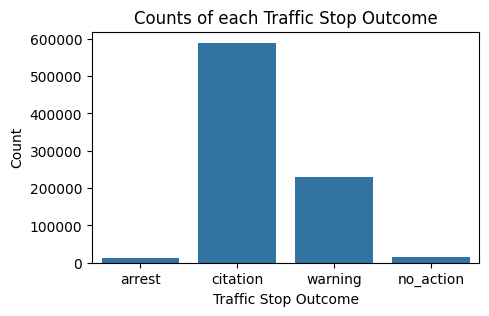

In [ ]:
plt.figure(figsize=(5, 3))
sns.countplot(data=df_clean, x="outcome",  order=outcome_order)
plt.title("Counts of each Traffic Stop Outcome", fontsize=12)
plt.xlabel("Traffic Stop Outcome", fontsize=10)
plt.ylabel("Count", fontsize=10)
plt.show()

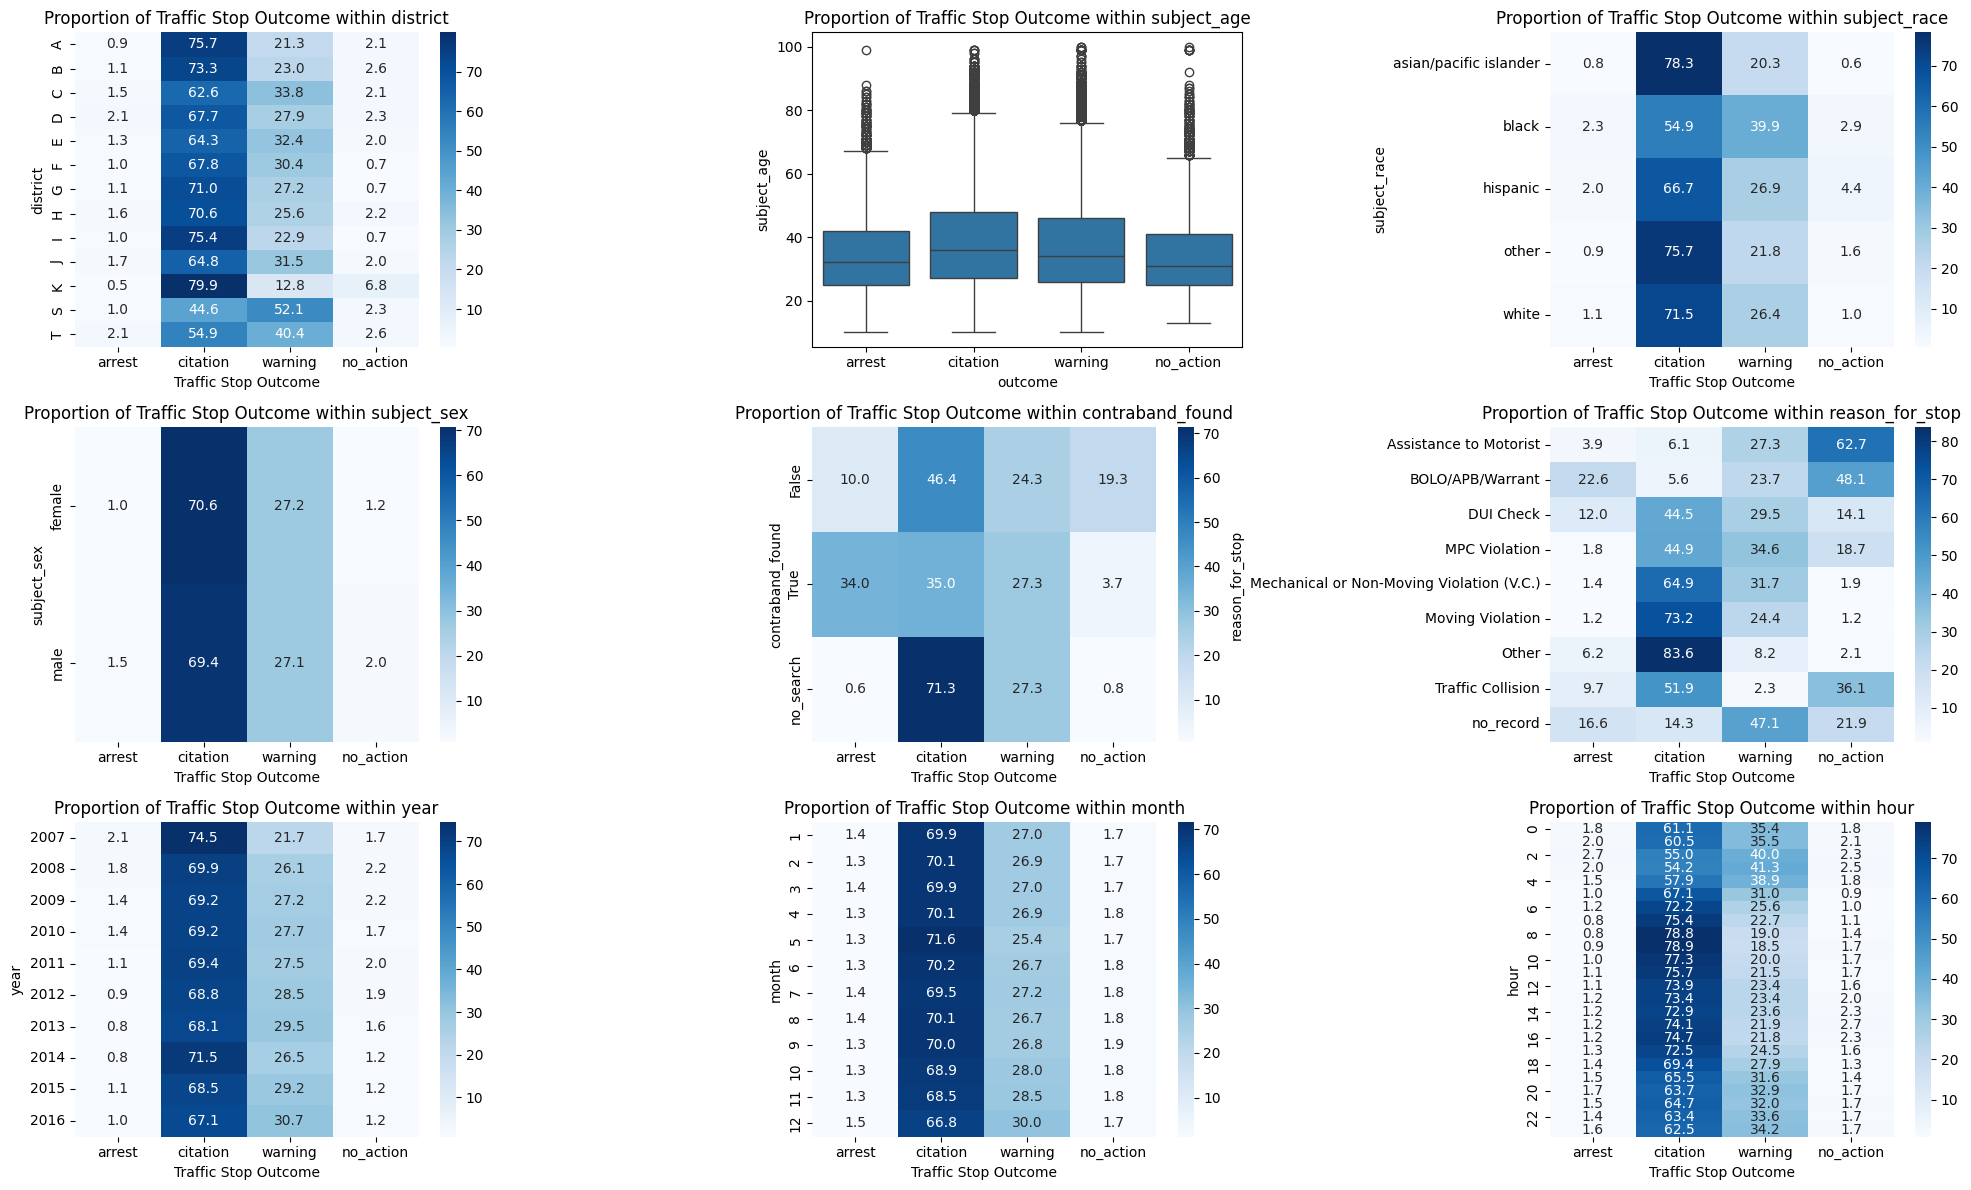

In [ ]:
columns = df_clean.columns.drop("outcome")

fig, axes = plt.subplots(3, 3, figsize=(20, 12))
axes = axes.flatten()

for i, col in enumerate(columns):
    ax = axes[i]
    if df_clean[col].dtype == "float64":
        sns.boxplot(data=df_clean, x="outcome", y=col, ax=ax, order=outcome_order)
        ax.set_ylabel(col, fontsize=10)
    else:
        pivot_table = pd.crosstab(df_clean[col], df_clean["outcome"], normalize="index") * 100
        sns.heatmap(pivot_table[outcome_order], annot=True, fmt=".1f", cmap='Blues', cbar=True, ax=ax)
        ax.set_ylabel(col, fontsize=10)
        ax.set_xlabel("Traffic Stop Outcome", fontsize=10)

    ax.set_title(f"Proportion of Traffic Stop Outcome within {col}", fontsize=12)

for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Data Preprocessing

Turn the data into one-hot

In [ ]:
# Process X

X_clean = df_clean.drop(columns = "outcome")
# Perform One-Hot Encoding for all categorical columns except "subject_age" and "hour"
X_one_hot = pd.get_dummies(
    X_clean,
    columns=[col for col in X_clean.columns if col not in ["subject_age", "hour"]],
    drop_first=True
)

X_one_hot.head()

subject_age hour  district_B  district_C  district_D  district_E  \
33159         56.0   10       False        True       False       False   
33160         32.0   10        True       False       False       False   
33161         57.0   10       False       False       False       False   
33162         31.0   10       False       False       False       False   
33163         37.0   10       False       False       False       False   

       district_F  district_G  district_H  district_I  ...  month_3  month_4  \
33159       False       False       False       False  ...    False    False   
33160       False       False       False       False  ...    False    False   
33161       False       False       False        True  ...    False    False   
33162       False       False       False       False  ...    False    False   
33163       False       False       False       False  ...    False    False   

       month_5  month_6  month_7  month_8  month_9  month_10  month_11  \
33159    False    False    False    False    False     False     False   
33160    False    False    False    False    False     False     False   
33161    False    False    False    False    False     False     False   
33162    False    False    False    False    False     False     False   
33163    False    False    False    False    False     False     False   

       month_12  
33159     False  
33160     False  
33161     False  
33162     False  
33163     False  

[5 rows x 49 columns]

In [ ]:
# Process Y

outcome_mapping = {"arrest": 0, "citation": 1, "warning": 2, "no_action": 3}
Y_number = df_clean["outcome"].map(outcome_mapping)

Y_number.unique()

array([1, 2, 0, 3])

In [ ]:
# Split the data into train and test sets (20% for test)
X_train, X_test, Y_train, Y_test = train_test_split(X_one_hot, Y_number, test_size=0.2, random_state=42)

# 4 Model Exploration

## Logistic Regression and Decision Tree (Don't need to run)

Fit simple logistic regression and decision tree, this cell takes quite a while to run, so I commented out. The remaining part of the notebook is just for exploration, no need to run. The results are written in the report.

In [ ]:
# # Train Decision Tree Classifier
# dt_model = DecisionTreeClassifier(random_state=42)
# dt_model.fit(X_train, Y_train)
# Y_pred_dt = dt_model.predict(X_test)

# # Train Logistic Regression
# lr_model = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
# lr_model.fit(X_train, Y_train)
# Y_pred_lr = lr_model.predict(X_test)

In [ ]:
# import numpy as np

# label_order = [outcome_mapping[key] for key in ["arrest", "citation", "warning", "no_action"]]

# # Decision Tree Confusion Matrix
# cm_dt = confusion_matrix(Y_test, Y_pred_dt, labels=label_order)

# # Logistic Regression Confusion Matrix
# cm_lr = confusion_matrix(Y_test, Y_pred_lr, labels=label_order)

# # Normalize confusion matrix by row (proportion)
# cm_dt_normalized = cm_dt.astype('float') / cm_dt.sum(axis=1)[:, np.newaxis]
# cm_lr_normalized = cm_lr.astype('float') / cm_lr.sum(axis=1)[:, np.newaxis]

# # Plot normalized confusion matrices
# fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# # Decision Tree Normalized Confusion Matrix
# disp_dt_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_dt_normalized, display_labels=list(outcome_mapping.keys()))
# disp_dt_normalized.plot(ax=axes[0], cmap="Blues", values_format=".2f")
# axes[0].set_title("Decision Tree Confusion Matrix (Normalized)")

# # Logistic Regression Normalized Confusion Matrix
# disp_lr_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_lr_normalized, display_labels=list(outcome_mapping.keys()))
# disp_lr_normalized.plot(ax=axes[1], cmap="Blues", values_format=".2f")
# axes[1].set_title("Logistic Regression Confusion Matrix (Normalized)")

# plt.tight_layout()
# plt.show()

In [ ]:
# # Calculate Accuracy and F1 Score for Decision Tree
# accuracy_dt = accuracy_score(Y_test, Y_pred_dt)
# f1_dt = f1_score(Y_test, Y_pred_dt, average='weighted')

# # Calculate Accuracy and F1 Score for Logistic Regression
# accuracy_lr = accuracy_score(Y_test, Y_pred_lr)
# f1_lr = f1_score(Y_test, Y_pred_lr, average='weighted')

# # Print the results
# print(f"Decision Tree Accuracy: {accuracy_dt:.2f}")
# print(f"Decision Tree F1 Score: {f1_dt:.2f}")
# print(f"Logistic Regression Accuracy: {accuracy_lr:.2f}")
# print(f"Logistic Regression F1 Score: {f1_lr:.2f}")

# 5 Downsampling and Class Imbalance Handling

## Downsamply Majority Classes

In [ ]:
from collections import Counter
from sklearn.utils import resample

# Combine features and target for easy manipulation
train_data = pd.concat([X_train, Y_train], axis=1)

# Define the desired number of samples per class after downsampling
# You can adjust this number based on your computational resources
desired_samples_per_class = 10000

# Separate each class
class_0 = train_data[train_data['outcome'] == 0]
class_1 = train_data[train_data['outcome'] == 1]
class_2 = train_data[train_data['outcome'] == 2]
class_3 = train_data[train_data['outcome'] == 3]

# Downsample majority classes
class_1_downsampled = resample(class_1,
                               replace=False,
                               n_samples=desired_samples_per_class,
                               random_state=42)
class_2_downsampled = resample(class_2,
                               replace=False,
                               n_samples=desired_samples_per_class,
                               random_state=42)
class_3_downsampled = resample(class_3,
                               replace=False,
                               n_samples=desired_samples_per_class,
                               random_state=42)

# Combine the downsampled classes with the minority class
train_balanced = pd.concat([class_0, class_1_downsampled, class_2_downsampled, class_3_downsampled])

# Shuffle the balanced training data
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and target
X_train_downsampled = train_balanced.drop('outcome', axis=1)
Y_train_downsampled = train_balanced['outcome']

# Check the new class distribution
print("Class distribution after downsampling:")
print(Counter(Y_train_downsampled))

Class distribution after downsampling:
Counter({1: 10000, 2: 10000, 3: 10000, 0: 9023})


## Handle class Imbalance (SMOTE)

In [ ]:
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

Y_number is imbalanced, which can significantly affect the performance of your models, especially for the minority classes. So SMOTE (Synthetic Minority Over-sampling Technique) is used to balance the classes in the training set.

In [ ]:
from imblearn.over_sampling import SMOTE

# Before applying SMOTE, check the class distribution in Y_train
print("Original class distribution in Y_train_downsampled:")
print(Counter(Y_train_downsampled))

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train_downsampled, Y_train_downsampled)

# After applying SMOTE, check the class distribution
print("Class distribution after applying SMOTE:")
print(Counter(Y_train_resampled))

Original class distribution in Y_train_downsampled:
Counter({1: 10000, 2: 10000, 3: 10000, 0: 9023})
Class distribution after applying SMOTE:
Counter({0: 10000, 1: 10000, 2: 10000, 3: 10000})


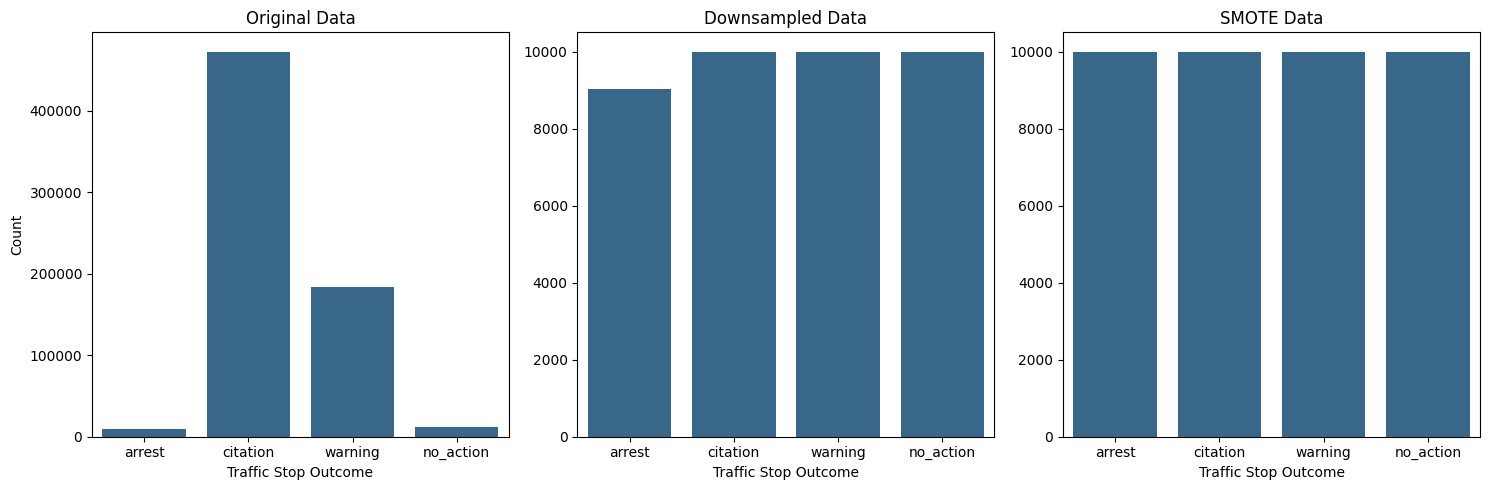

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Create example data
original_data = pd.DataFrame({
    'outcome': np.repeat(['arrest', 'citation', 'warning', 'no_action'], [9023, 472346, 183646, 11903])
})
downsampled_data = pd.DataFrame({
    'outcome': np.repeat(['arrest', 'citation', 'warning', 'no_action'], [9023, 10000, 10000, 10000])
})
smote_data = pd.DataFrame({
    'outcome': np.repeat(['arrest', 'citation', 'warning', 'no_action'], [10000, 10000, 10000, 10000])
})

# Set outcome order
outcome_order = ['arrest', 'citation', 'warning', 'no_action']

# Define a custom color palette with the specific color
custom_palette = ['#2c6997'] * len(outcome_order)

# Create a figure for the subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Remove sharey=True

# Original data distribution
sns.countplot(ax=axes[0], data=original_data, x='outcome', hue='outcome', order=outcome_order, palette=custom_palette, legend=False)
axes[0].set_title('Original Data', fontsize=12)
axes[0].set_xlabel('Traffic Stop Outcome', fontsize=10)
axes[0].set_ylabel('Count', fontsize=10)

# Downsampled data distribution
sns.countplot(ax=axes[1], data=downsampled_data, x='outcome', hue='outcome', order=outcome_order, palette=custom_palette, legend=False)
axes[1].set_title('Downsampled Data', fontsize=12)
axes[1].set_xlabel('Traffic Stop Outcome', fontsize=10)
axes[1].set_ylabel('')  # Remove ylabel to avoid redundancy

# SMOTE data distribution
sns.countplot(ax=axes[2], data=smote_data, x='outcome', hue='outcome', order=outcome_order, palette=custom_palette, legend=False)
axes[2].set_title('SMOTE Data', fontsize=12)
axes[2].set_xlabel('Traffic Stop Outcome', fontsize=10)
axes[2].set_ylabel('')  # Remove ylabel to avoid redundancy

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Split the resampled data into final train and validation sets (20% for test)

In [ ]:
X_train_final, X_val, Y_train_final, Y_val = train_test_split(
    X_train_resampled, Y_train_resampled, test_size=0.2, random_state=42, stratify=Y_train_resampled
)

print(f"Final training set size: {X_train_final.shape}")
print(f"Validation set size: {X_val.shape}")

Final training set size: (32000, 49)
Validation set size: (8000, 49)


# 6 Model Training and Hyperparameter Tuning

## Decision Tree

Hyperparameter Tuning with Cross-Validation

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Decision Tree
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Use GridSearchCV for hyperparameter tuning
grid_search_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid_dt,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

# Fit the model
grid_search_dt.fit(X_train_final, Y_train_final)

# Best parameters
print("Best parameters for Decision Tree:")
print(grid_search_dt.best_params_)

# Best estimator
best_dt = grid_search_dt.best_estimator_

Best parameters for Decision Tree:
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}


**Best parameters for Decision Tree:**

{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}

Evaluate Decision Tree on Validation Set

Decision Tree Classification Report on Validation Set:
              precision    recall  f1-score   support

      arrest       0.70      0.43      0.53      2000
    citation       0.47      0.51      0.49      2000
     warning       0.41      0.53      0.46      2000
   no_action       0.62      0.64      0.63      2000

    accuracy                           0.53      8000
   macro avg       0.55      0.53      0.53      8000
weighted avg       0.55      0.53      0.53      8000



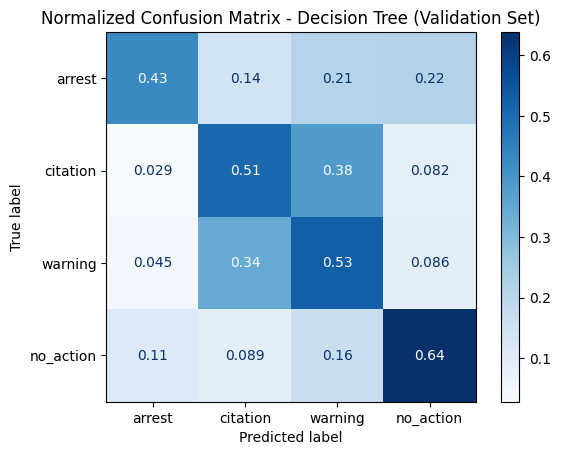

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict on validation set
Y_val_pred_dt = best_dt.predict(X_val)

# Classification report
print("Decision Tree Classification Report on Validation Set:")
print(classification_report(Y_val, Y_val_pred_dt, target_names=outcome_mapping.keys()))

# Confusion matrix
cm_val_dt = confusion_matrix(Y_val, Y_val_pred_dt, normalize='true')
disp_val_dt = ConfusionMatrixDisplay(confusion_matrix=cm_val_dt, display_labels=outcome_mapping.keys())
disp_val_dt.plot(cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix - Decision Tree (Validation Set)')
plt.show()

Evaluate Decision Tree on Test Set

Decision Tree Classification Report on Test Set:
              precision    recall  f1-score   support

      arrest       0.14      0.40      0.21      2296
    citation       0.79      0.51      0.62    117738
     warning       0.35      0.53      0.42     46146
   no_action       0.13      0.64      0.21      3050

    accuracy                           0.52    169230
   macro avg       0.35      0.52      0.37    169230
weighted avg       0.65      0.52      0.55    169230



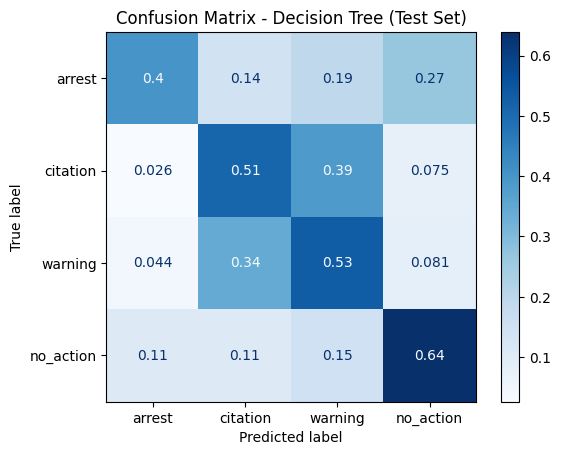

In [ ]:
# Predict on test set
Y_test_pred_dt = best_dt.predict(X_test)

# Classification report
print("Decision Tree Classification Report on Test Set:")
print(classification_report(Y_test, Y_test_pred_dt, target_names=outcome_mapping.keys()))

# Confusion matrix
cm_test_dt = confusion_matrix(Y_test, Y_test_pred_dt, normalize='true')
disp_test_dt = ConfusionMatrixDisplay(confusion_matrix=cm_test_dt, display_labels=outcome_mapping.keys())
disp_test_dt.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Decision Tree (Test Set)')
plt.show()

Evaluation of the performance:

Validation Set Accuracy: 53%; Test Set Accuracy: 52%

Despite downsampling and applying SMOTE, the classes might still be imbalanced or the synthetic samples might not fully capture the diversity of the minority classes.

To improve, we will try more complex models.

## Random Forest

Hyperparameter Tuning with Cross-Validation

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    # 'bootstrap': [True, False]
}

# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Use GridSearchCV for hyperparameter tuning
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='f1_macro',
    verbose=1
)

# Fit the model
grid_search_rf.fit(X_train_final, Y_train_final)

# Best parameters
print("Best parameters for Random Forest:")
print(grid_search_rf.best_params_)

# Best estimator
best_rf = grid_search_rf.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters for Random Forest:
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


**Best parameters for Random Forest:**

{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

Evaluating Random Forest on Validation Set

Random Forest Classification Report on Validation Set:
              precision    recall  f1-score   support

      arrest       0.69      0.51      0.59      2000
    citation       0.46      0.60      0.52      2000
     warning       0.44      0.46      0.45      2000
   no_action       0.70      0.65      0.67      2000

    accuracy                           0.55      8000
   macro avg       0.57      0.55      0.56      8000
weighted avg       0.57      0.55      0.56      8000



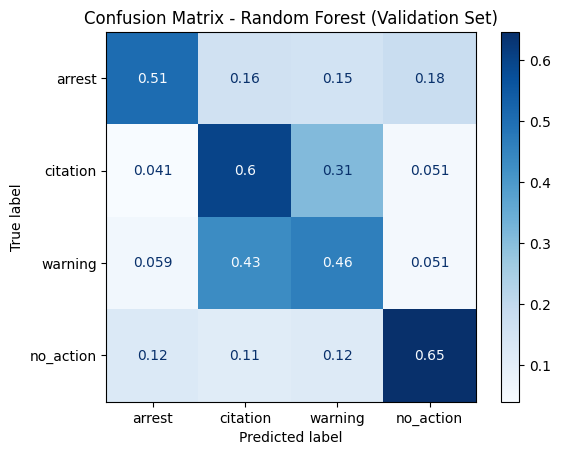

In [ ]:
# Predict on validation set
Y_val_pred_rf = best_rf.predict(X_val)

# Classification report for validation set
print("Random Forest Classification Report on Validation Set:")
print(classification_report(Y_val, Y_val_pred_rf, target_names=outcome_mapping.keys()))

# Confusion matrix for validation set
cm_val_rf = confusion_matrix(Y_val, Y_val_pred_rf, normalize='true')
disp_val_rf = ConfusionMatrixDisplay(confusion_matrix=cm_val_rf, display_labels=outcome_mapping.keys())
disp_val_rf.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Random Forest (Validation Set)')
plt.show()

Evaluate Random Forest on Test Set

Random Forest Classification Report on Test Set:
              precision    recall  f1-score   support

      arrest       0.13      0.47      0.21      2296
    citation       0.78      0.60      0.68    117738
     warning       0.37      0.47      0.41     46146
   no_action       0.19      0.64      0.29      3050

    accuracy                           0.57    169230
   macro avg       0.37      0.55      0.40    169230
weighted avg       0.65      0.57      0.59    169230



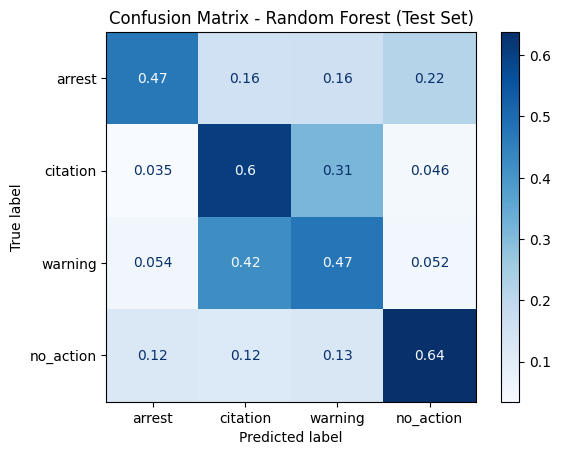

In [ ]:
# Predict on test set
Y_test_pred_rf = best_rf.predict(X_test)

# Classification report for test set
print("Random Forest Classification Report on Test Set:")
print(classification_report(Y_test, Y_test_pred_rf, target_names=outcome_mapping.keys()))

# Confusion matrix for test set
cm_test_rf = confusion_matrix(Y_test, Y_test_pred_rf, normalize='true')
disp_test_rf = ConfusionMatrixDisplay(confusion_matrix=cm_test_rf, display_labels=outcome_mapping.keys())
disp_test_rf.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Random Forest (Test Set)')
plt.show()

Evaluation of the performance:

Validation Set Accuracy: 55%; Test Set Accuracy: 57%

The performance of random forest is better than decision tree. However, a drop of Macro Avg from 0.56 to 0.40 indicates poorer performance across all classes, especially minority ones.

To improve, we will try another complex models.

## Neural Network

Hyperparameter Tuning with Cross-Validation

In [ ]:
# from sklearn.neural_network import MLPClassifier

# # Define parameter grid for Neural Network
# param_grid_nn = {
#     'hidden_layer_sizes': [(100,), (100, 50)],
#     'activation': ['relu'],
#     'alpha': [ 0.001],
#     'learning_rate': ['adaptive']
# }

# # Initialize MLPClassifier
# nn = MLPClassifier(max_iter=200, random_state=42)

# # Use GridSearchCV for hyperparameter tuning
# grid_search_nn = GridSearchCV(
#     estimator=nn,
#     param_grid=param_grid_nn,
#     cv=5,
#     scoring='f1_macro',
#     n_jobs=-1,
#     verbose=2
# )

# # Fit the model
# grid_search_nn.fit(X_train_final, Y_train_final)

# # Best parameters
# print("Best parameters for Neural Network:")
# print(grid_search_nn.best_params_)

# # Best estimator
# best_nn = grid_search_nn.best_estimator_

It will cause ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet

To solve it, StandardScale is used to standardlized data

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# create a standardScale and neural network pipline
pipeline_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(max_iter=200, random_state=42,early_stopping=True ))
])

# Define parameter grid for Neural Network
param_grid_nn = {
    'mlp__hidden_layer_sizes': [(100,), (100, 50)],
    'mlp__activation': ['relu'],
    'mlp__alpha': [0.001],
    'mlp__learning_rate': ['adaptive']
}

# Initialize MLPClassifier
nn = MLPClassifier(max_iter=200, random_state=42)

# Use GridSearchCV for hyperparameter tuning
grid_search_nn = GridSearchCV(
    estimator=pipeline_nn,
    param_grid=param_grid_nn,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

# Fit the model
grid_search_nn.fit(X_train_final, Y_train_final)

# Best parameters
print("Best parameters for Neural Network:")
print(grid_search_nn.best_params_)

# Best estimator
best_nn = grid_search_nn.best_estimator_

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters for Neural Network:
{'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate': 'adaptive'}


**Best parameters for Neural Network:**

{'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate': 'adaptive'}

Evaluate Neural Network on Validation Set

Neural Network Classification Report on Validation Set:
              precision    recall  f1-score   support

      arrest       0.64      0.53      0.58      2000
    citation       0.46      0.62      0.52      2000
     warning       0.44      0.40      0.42      2000
   no_action       0.69      0.63      0.66      2000

    accuracy                           0.54      8000
   macro avg       0.56      0.54      0.55      8000
weighted avg       0.56      0.54      0.55      8000



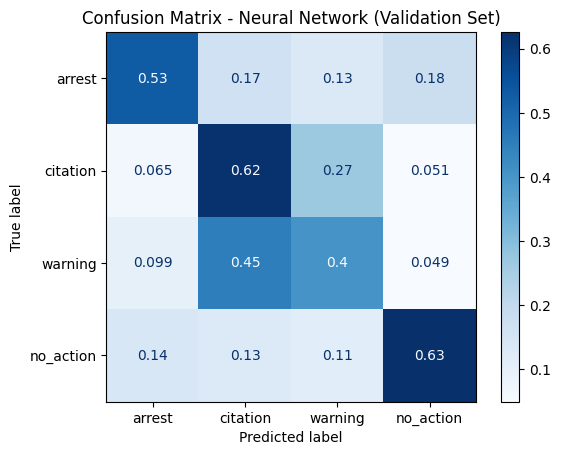

In [ ]:
# Predict on validation set
Y_val_pred_nn = best_nn.predict(X_val)

# Classification report
print("Neural Network Classification Report on Validation Set:")
print(classification_report(Y_val, Y_val_pred_nn, target_names=outcome_mapping.keys()))

# Confusion matrix
cm_val_nn = confusion_matrix(Y_val, Y_val_pred_nn, normalize='true')
disp_val_nn = ConfusionMatrixDisplay(confusion_matrix=cm_val_nn, display_labels=outcome_mapping.keys())
disp_val_nn.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Neural Network (Validation Set)')
plt.show()

Evaluate Neural Network on Test Set

Neural Network Classification Report:
              precision    recall  f1-score   support

      arrest       0.09      0.48      0.15      2296
    citation       0.77      0.62      0.69    117738
     warning       0.37      0.42      0.39     46146
   no_action       0.19      0.61      0.29      3050

    accuracy                           0.56    169230
   macro avg       0.35      0.53      0.38    169230
weighted avg       0.64      0.56      0.59    169230



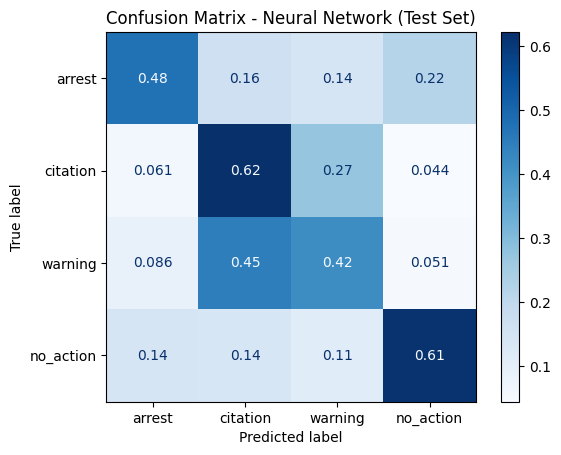

In [ ]:
# Predict on test set
Y_test_pred_nn = best_nn.predict(X_test)

# Classification report
print("Neural Network Classification Report:")
print(classification_report(Y_test, Y_test_pred_nn, target_names=outcome_mapping.keys()))

# Confusion matrix
cm_test_nn = confusion_matrix(Y_test, Y_test_pred_nn, normalize='true')
disp_test_nn = ConfusionMatrixDisplay(confusion_matrix=cm_test_nn, display_labels=outcome_mapping.keys())
disp_test_nn.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Neural Network (Test Set)')
plt.show()

Evaluation of the performance:

Validation Set Accuracy: 55%; Test Set Accuracy: 56%

Similarly, the performance of neural network is better than decision tree, but not better than random forest. A drop of Macro Avg from 0.55 to 0.37 indicates poorer performance across all classes, especially minority ones.

The Neural Network (MLPClassifier) shows moderate overall accuracy but struggles with minority classes ("arrest" and "no_action").

## Logistic Regression

Hyperparameter Tuning with Cross-Validation

In [ ]:
from sklearn.linear_model import LogisticRegression

# Define a pipeline with scaling and Logistic Regression
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),  # Scaling is crucial for Logistic Regression
    ('lr', LogisticRegression(random_state=42, max_iter=1000))
])

# Define parameter grid for Logistic Regression
param_grid_lr = {
    'lr__C': [0.1, 1, 10],
    'lr__penalty': ['l1', 'l2'],
    'lr__solver': ['liblinear']
}

# Initialize Logistic Regression Classifier
lr = LogisticRegression(random_state=42, max_iter=1000)

# Use GridSearchCV for hyperparameter tuning
grid_search_lr = GridSearchCV(
    estimator=pipeline_lr,
    param_grid=param_grid_lr,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

# Fit the model
grid_search_lr.fit(X_train_final, Y_train_final)

# Best parameters
print("Best parameters for Logistic Regression:")
print(grid_search_lr.best_params_)

# Best estimator
best_lr = grid_search_lr.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters for Logistic Regression:
{'lr__C': 10, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}


**Best parameters for Logistic Regression:**

{'lr__C': 10, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}

Evaluate Logistic Regression on Validation Set

Logistic Regression Classification Report on Validation Set:
              precision    recall  f1-score   support

      arrest       0.71      0.38      0.49      2000
    citation       0.44      0.62      0.51      2000
     warning       0.41      0.43      0.42      2000
   no_action       0.62      0.63      0.63      2000

    accuracy                           0.51      8000
   macro avg       0.54      0.51      0.51      8000
weighted avg       0.54      0.51      0.51      8000



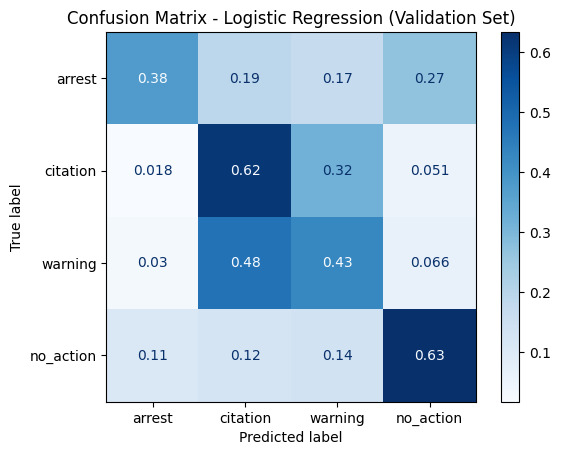

In [ ]:
# Predict on validation set
Y_val_pred_lr = best_lr.predict(X_val)

# Classification report
print("Logistic Regression Classification Report on Validation Set:")
print(classification_report(Y_val, Y_val_pred_lr, target_names=outcome_mapping.keys()))

# Confusion matrix
cm_val_lr = confusion_matrix(Y_val, Y_val_pred_lr, normalize='true')
disp_val_lr = ConfusionMatrixDisplay(confusion_matrix=cm_val_lr, display_labels=outcome_mapping.keys())
disp_val_lr.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Logistic Regression (Validation Set)')
plt.show()

Evaluate Logistic Regression on Validation Set

Logistic Regression Classification Report:
              precision    recall  f1-score   support

      arrest       0.20      0.34      0.25      2296
    citation       0.77      0.63      0.69    117738
     warning       0.36      0.45      0.40     46146
   no_action       0.18      0.62      0.27      3050

    accuracy                           0.57    169230
   macro avg       0.37      0.51      0.40    169230
weighted avg       0.64      0.57      0.60    169230



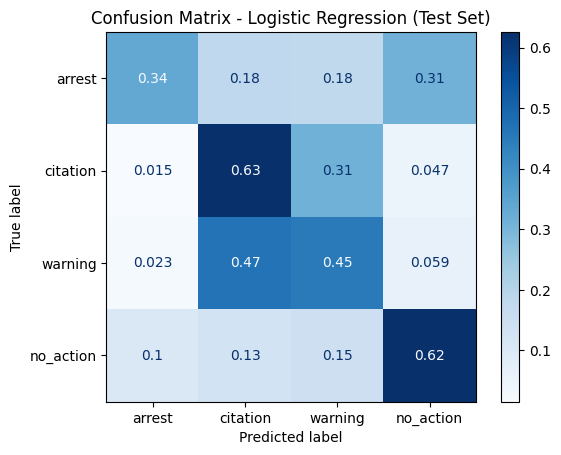

In [ ]:
# Predict on test set
Y_test_pred_lr = best_lr.predict(X_test)

# Classification report
print("Logistic Regression Classification Report:")
print(classification_report(Y_test, Y_test_pred_lr, target_names=outcome_mapping.keys()))

# Confusion matrix
cm_test_lr = confusion_matrix(Y_test, Y_test_pred_lr, normalize='true')
disp_test_lr = ConfusionMatrixDisplay(confusion_matrix=cm_test_lr, display_labels=outcome_mapping.keys())
disp_test_lr.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Logistic Regression (Test Set)')
plt.show()

Evaluation of the performance:

Validation Set Accuracy: 51%; Test Set Accuracy: 57%

Similarly, the performance of logistic regression on test data is better than decision tree.

The Logistic Regression shows moderate overall accuracy but struggles with minority classes ("arrest" and "no_action"), ensemble learning can be a method to explore.

## Ensemble Learning (Voting Classifier) - Better



### Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

# Create a Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('dt', best_dt),
        ('rf', best_rf),
        ('nn', best_nn),
        ('lr', best_lr)
    ],
    voting='soft'  # Use soft voting to consider predicted probabilities
)

# Train the Ensemble Model
voting_clf.fit(X_train_final, Y_train_final)

VotingClassifier(estimators=[('dt',
                              DecisionTreeClassifier(max_depth=10,
                                                     min_samples_leaf=2,
                                                     min_samples_split=10,
                                                     random_state=42)),
                             ('rf',
                              RandomForestClassifier(max_depth=20,
                                                     min_samples_split=5,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('nn',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('mlp',
                                               MLPClassifier(alpha=0.001,
                                                             early_stopping=True,
                                                             learning_rate='adaptive',
                                                             random_state=42))])),
                             ('lr',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('lr',
                                               LogisticRegression(C=10,
                                                                  max_iter=1000,
                                                                  random_state=42,
                                                                  solver='liblinear'))]))],
                 voting='soft')

In [ ]:
from graphviz import Digraph

# Create a Digraph object
dot = Digraph(format="png")
dot.attr(rankdir='LR')  # Left-to-right layout

# Add the VotingClassifier node
dot.node("VotingClassifier", "VotingClassifier\n(voting='soft')", shape="box", style="filled", color="#AEDFF7")

# Define the estimators with lighter shades of blue
estimators = {
    "dt": "DecisionTreeClassifier\nmax_depth=10\nmin_samples_leaf=2\nmin_samples_split=10\nrandom_state=42",
    "rf": "RandomForestClassifier\nmax_depth=20\nmin_samples_split=5\nn_estimators=200\nrandom_state=42",
    "nn": "Pipeline\nStandardScaler -> MLPClassifier\nalpha=0.001\nearly_stopping=True\nlearning_rate='adaptive'\nrandom_state=42",
    "lr": "Pipeline\nStandardScaler -> LogisticRegression\nC=10\nmax_iter=1000\nsolver='liblinear'\nrandom_state=42"
}

# Lighter shades of blue for improved readability
colors = {
    "dt": "#B3E5FC",
    "rf": "#BBDEFB",
    "nn": "#E3F2FD",
    "lr": "#F0F4F8"
}

for key, label in estimators.items():
    dot.node(key, label, shape="box", style="filled", color=colors[key], fontcolor="black")
    dot.edge("VotingClassifier", key)

# Render the graph
dot.render("voting_classifier_diagram_lightblue", view=True)


'voting_classifier_diagram_lightblue.png'

Evaluate Voting Classifier on Validation Set

Voting Classifier Classification Report on Validation Set:
              precision    recall  f1-score   support

      arrest       0.72      0.48      0.57      2000
    citation       0.46      0.64      0.53      2000
     warning       0.44      0.43      0.44      2000
   no_action       0.69      0.65      0.67      2000

    accuracy                           0.55      8000
   macro avg       0.58      0.55      0.55      8000
weighted avg       0.58      0.55      0.55      8000



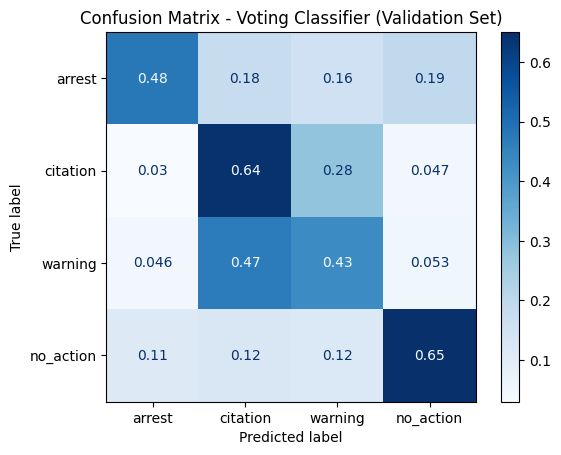

In [ ]:
# Predict on validation set
Y_val_pred_voting = voting_clf.predict(X_val)

# Classification report
print("Voting Classifier Classification Report on Validation Set:")
print(classification_report(Y_val, Y_val_pred_voting, target_names=outcome_mapping.keys()))

# Confusion matrix
cm_val_voting = confusion_matrix(Y_val, Y_val_pred_voting, normalize='true')
disp_val_voting = ConfusionMatrixDisplay(confusion_matrix=cm_val_voting, display_labels=outcome_mapping.keys())
disp_val_voting.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Voting Classifier (Validation Set)')
plt.show()

Evaluate Voting Classifier on Test Set

Voting Classifier Classification Report on Test Set:
              precision    recall  f1-score   support

      arrest       0.14      0.42      0.21      2296
    citation       0.78      0.65      0.71    117738
     warning       0.38      0.45      0.41     46146
   no_action       0.20      0.65      0.31      3050

    accuracy                           0.59    169230
   macro avg       0.38      0.54      0.41    169230
weighted avg       0.65      0.59      0.61    169230



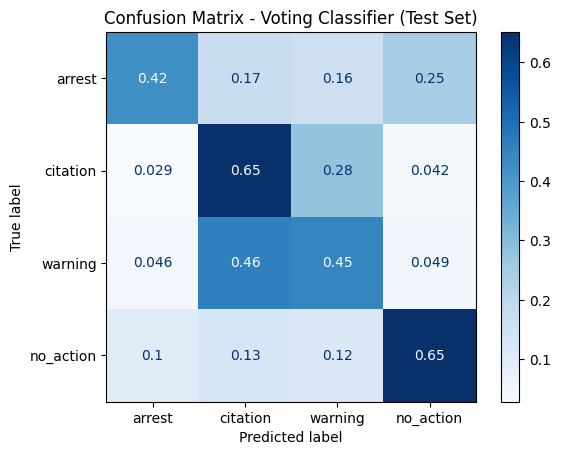

In [ ]:
# Predict on test set using Voting Classifier
Y_test_pred_voting = voting_clf.predict(X_test)

# Classification report
print("Voting Classifier Classification Report on Test Set:")
print(classification_report(Y_test, Y_test_pred_voting, target_names=outcome_mapping.keys()))

# Confusion Matrix
cm_test_voting = confusion_matrix(Y_test, Y_test_pred_voting, normalize='true')
disp_test_voting = ConfusionMatrixDisplay(confusion_matrix=cm_test_voting, display_labels=outcome_mapping.keys())
disp_test_voting.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Voting Classifier (Test Set)')
plt.show()

Evaluation of the performance:

Validation Set Accuracy: 55%; Test Set Accuracy: 59%

Similarly, the performance of ensemble with voting classifer on whole test set is better than single model.

To improve the performance on imbalanced data, some other ensemeble learning methods need to explore.

## Ensemble Learning (Stacking Classifier) - (Don't need to run)

### Fine-tune the Meta-learner (Logistic Regression)

create a pipeline

In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neural_network import MLPClassifier

# # Define the pipeline for Decision Tree
# pipeline_dt = Pipeline([
#     ('dt', DecisionTreeClassifier(
#         random_state=42,
#         class_weight='balanced',  # Handles class imbalance
#         max_depth=10,             # Tuned based on previous GridSearchCV
#         min_samples_split=10,
#         min_samples_leaf=2
#     ))
# ])

# # Define the pipeline for Random Forest
# pipeline_rf = Pipeline([
#     ('rf', RandomForestClassifier(
#         n_estimators=200,
#         random_state=42,
#         class_weight='balanced',  # Handles class imbalance
#         max_depth=20,
#         min_samples_split=5,
#         min_samples_leaf=1,
#         n_jobs=-1
#     ))
# ])

# # Define the pipeline for Neural Network
# pipeline_nn = Pipeline([
#     ('scaler', StandardScaler()),  # Essential for Neural Networks
#     ('nn', MLPClassifier(
#         hidden_layer_sizes=(100,),
#         activation='relu',
#         alpha=0.001,
#         learning_rate='adaptive',
#         learning_rate_init=0.01,
#         max_iter=300,             # Increased to aid convergence
#         random_state=42,
#         early_stopping=True,      # Enables early stopping to prevent overfitting
#         validation_fraction=0.1,  # Fraction of training data for validation
#         n_iter_no_change=10       # Number of iterations with no improvement to wait before stopping
#     ))
# ])

In [ ]:
# from sklearn.ensemble import StackingClassifier
# from sklearn.linear_model import LogisticRegression

# # Define base learners
# base_learners = [
#         ('dt', best_dt),
#         ('rf', best_rf),
#         ('nn', best_nn),
#         ('lr', best_lr)
# ]

# # Define meta-learner
# meta_learner = LogisticRegression(random_state=42, max_iter=1000)

# # Initialize StackingClassifier
# stacking_clf = StackingClassifier(
#     estimators=base_learners,
#     final_estimator=meta_learner,
#     cv=5,                # Cross-validation folds
#     n_jobs=-1,
#     passthrough=False,   # Whether to use original features along with base learners' predictions
#     verbose=2
# )

# # Train the StackingClassifier
# stacking_clf.fit(X_train_final, Y_train_final)

Evaluate Stacking Classifier on Validation Set

In [ ]:
# # Predict on validation set using Stacking Classifier
# Y_val_pred_stacking = stacking_clf.predict(X_val)

# # Classification report
# print("Stacking Classifier Validation Set Classification Report:")
# print(classification_report(Y_val, Y_val_pred_stacking, target_names=outcome_mapping.keys()))

# # Confusion matrix
# cm_val_stacking = confusion_matrix(Y_val, Y_val_pred_stacking, normalize='true')
# disp_val_stacking = ConfusionMatrixDisplay(confusion_matrix=cm_val_stacking, display_labels=outcome_mapping.keys())
# disp_val_stacking.plot(cmap=plt.cm.Blues)
# plt.title('Confusion Matrix - Stacked Ensemble (Validation Set)')
# plt.show()

Evaluate Stacking Classifier on Test Set

In [ ]:
# # Predict on test set using Stacking Classifier
# Y_test_pred_stacking = stacking_clf.predict(X_test)

# # Classification report
# print("Stacking Classifier Test Set Classification Report:")
# print(classification_report(Y_test, Y_test_pred_stacking, target_names=outcome_mapping.keys()))

# # Confusion Matrix
# cm_test_stacking = confusion_matrix(Y_test, Y_test_pred_stacking, normalize='true')
# disp_test_stacking = ConfusionMatrixDisplay(confusion_matrix=cm_test_stacking, display_labels=outcome_mapping.keys())
# disp_test_stacking.plot(cmap=plt.cm.Blues)
# plt.title('Confusion Matrix - Stacked Ensemble (Test Set)')
# plt.show()

### Fine-tune the Meta-learner (XGBooster)

In [ ]:
# from xgboost import XGBClassifier

# # Define a more complex meta-learner using XGBoost
# meta_learner_xgb = XGBClassifier(
#     use_label_encoder=False,
#     eval_metric='mlogloss',
#     random_state=42
# )

# # Initialize a new StackingClassifier with XGBoost as the meta-learner
# stacking_clf_xgb = StackingClassifier(
#     estimators=base_learners,
#     final_estimator=meta_learner_xgb,
#     cv=5,
#     n_jobs=-1,
#     passthrough=False,
#     verbose=2
# )

# # Train the new StackingClassifier
# stacking_clf_xgb.fit(X_train_final, Y_train_final)

Evaluate Stacking Classifier (XGBClassifer) on Valdiation Set

In [ ]:
# # Predict on validation set using Stacking Classifier
# Y_val_pred_stacking_xgb = stacking_clf_xgb.predict(X_val)

# # Classification report
# print("Stacking Classifier Validation Set Classification Report:")
# print(classification_report(Y_val, Y_val_pred_stacking_xgb, target_names=outcome_mapping.keys()))

# # Confusion matrix
# cm_val_stacking_xgb = confusion_matrix(Y_val, Y_val_pred_stacking_xgb, normalize='true')
# disp_val_stacking_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_val_stacking_xgb, display_labels=outcome_mapping.keys())
# disp_val_stacking_xgb.plot(cmap=plt.cm.Blues)
# plt.title('Confusion Matrix - Stacked Ensemble with XGBoost (Validation Set)')
# plt.show()

Evaluate Stacking Classifier (XGBClassifer) on Test Set

In [ ]:
# # Predict on test set using Stacking Classifier
# Y_test_pred_stacking_xgb = stacking_clf_xgb.predict(X_test)

# # Classification report
# print("Stacking Ensemble with XGBoost Meta-Learner Classification Report on Test Set:")
# print(classification_report(Y_test, Y_test_pred_stacking_xgb, target_names=outcome_mapping.keys()))

# # Confusion Matrix
# cm_stacking_xgb = confusion_matrix(Y_test, Y_test_pred_stacking_xgb, normalize='true')
# disp_stacking_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_stacking_xgb, display_labels=outcome_mapping.keys())
# disp_stacking_xgb.plot(cmap=plt.cm.Blues)
# plt.title('Confusion Matrix - Stacked Ensemble with XGBoost (Test Set)')
# plt.show()

The performace of stacking ensemble with an XGBoost meta-learner is pooer than individal models.

To improve it, we will try different meta-learners.

### Fine-tune the Meta-learner (GradientBoosting) - Better

In [ ]:
# from sklearn.ensemble import GradientBoostingClassifier

# # Define a Gradient Boosting meta-learner
# meta_learner_gb = GradientBoostingClassifier(
#     n_estimators=100,
#     learning_rate=0.1,
#     max_depth=3,
#     random_state=42
# )

# # Initialize StackingClassifier with the new meta-learner
# stacking_clf_gb = StackingClassifier(
#     estimators=base_learners,
#     final_estimator=meta_learner_gb,
#     cv=5,
#     n_jobs=-1,
#     passthrough=False,
#     verbose=2
# )

# # Train the StackingClassifier
# stacking_clf_gb.fit(X_train_final, Y_train_final)

Evaluate Stacking Classifier (GradientBoostingClassifier) on Valdiation Set

In [ ]:
# # Predict on validation set using Stacking Classifier
# Y_val_pred_stacking_gb = stacking_clf_gb.predict(X_val)

# # Classification report
# print("Stacking Ensemble with GradientBoosting Meta-Learner Classification Report on Validation Set:")
# print(classification_report(Y_val, Y_val_pred_stacking_gb, target_names=outcome_mapping.keys()))

# # Confusion matrix
# cm_val_stacking_gb = confusion_matrix(Y_val, Y_val_pred_stacking_gb, normalize='true')
# disp_val_stacking_gb = ConfusionMatrixDisplay(confusion_matrix=cm_val_stacking_gb, display_labels=outcome_mapping.keys())
# disp_val_stacking_gb.plot(cmap=plt.cm.Blues)
# plt.title('Confusion Matrix - Stacked Ensemble with XGBoost (Validation Set)')
# plt.show()

Evaluate Stacking Classifier (GradientBoostingClassifier) on Test Set

In [ ]:
# # Predict on test set using Voting Classifier
# Y_test_pred_stacking_gb = stacking_clf_gb.predict(X_test)

# # Classification report
# print("Stacking Ensemble with GradientBoosting Meta-Learner Classification Report on Test Set:")
# print(classification_report(Y_test, Y_test_pred_stacking_gb, target_names=outcome_mapping.keys()))

# # Confusion Matrix
# cm_stacking_gb = confusion_matrix(Y_test, Y_test_pred_stacking_gb, normalize='true')
# disp_stacking_gb = ConfusionMatrixDisplay(confusion_matrix=cm_stacking_gb, display_labels=outcome_mapping.keys())
# disp_stacking_gb.plot(cmap=plt.cm.Blues)
# plt.title('Confusion Matrix - Stacked Ensemble with GradientBoosting (Test Set)')
# plt.show()

The performace of stacking ensemble with an GradientBoosting meta-learner is better than that with an XGBoost meta-learner.


Evaluation of the performance:

Validation Set Accuracy: 56%; Test Set Accuracy: 55%

Compared to voting classifer, the stacking classifer has a poorer performance, so ensemble learning with voting classifer is a better ensemble method.

## Final Model and Analysis

**Decision Tree, Random Forest, Neural Network, and Logistic Regression—and combined them using a Voting Classifier**

Overall Accuracy: 59%

Minority Classes ("arrest" and "no_action"): The model has difficulty accurately predicting these classes, as evidenced by low precision scores. This means that many instances predicted as "arrest" or "no_action" are incorrect.

Majority Class ("citation"): The model performs well, which is expected given its prevalence in the dataset.

# 7 Data Interpretation (GEO)

## 7.1 Data with Location

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from scipy.stats import chi2_contingency
import shap

In [ ]:
#data_resampled = pd.concat([X_train_resampled, Y_train_resampled], axis=1)
#data_resampled.head()

In [ ]:
data = df.drop(columns = ["raw_row_number", "location", "arrest_made", "citation_issued", "warning_issued", "search_basis", 'type','raw_result_of_contact_description','raw_search_vehicle_description'])
# drop those missing time or age as those are important features we are going to model on
data = data[~((data["time"].isna()) | (data["subject_age"].isna()))]

# Get year and month from data; get hour from time, and drop original columns
data['year'] = pd.to_datetime(data['date'], format='%Y-%m-%d').dt.year.astype(object)
data['month'] = pd.to_datetime(data['date'], format='%Y-%m-%d').dt.month.astype(object)
data['hour'] = pd.to_datetime(data['time'], format='%H:%M:%S').dt.hour.astype(object)
data = data.drop(columns=['date', 'time'])

# According to definition, update NaNs in contraband_found according to search_conducted
data['contraband_found'] = data.apply(
    lambda row: "no_search" if pd.isna(row['contraband_found']) and row['search_conducted'] == False else row['contraband_found'],
    axis=1
)
# delete this since contraband_found already covers the info
data = data.drop(columns = ['search_conducted', "search_vehicle"])

# For columns reason_for_stop, messy categories has below 200 instances. So we merge them into Other
reason_counts = data['reason_for_stop'].value_counts()
data['reason_for_stop'] = data['reason_for_stop'].replace(reason_counts[reason_counts <= 200].index, "Other")

# change NaN in outcome to no_action
data['outcome'] = data['outcome'].fillna('no_action')

# change NaN in district to no_record
data['district'] = data['district'].fillna('no_record')

# change NaN in reason_for_stop to no_record
data['reason_for_stop'] = data['reason_for_stop'].fillna('no_record')

# Drop rows with NaN values in either 'lat' or 'lng'
data = data.dropna(subset=['lat', 'lng'])

# Verify the changes
nan_counts_clean = data.isna().sum()
print(nan_counts_clean)

lat                 0
lng                 0
district            0
subject_age         0
subject_race        0
subject_sex         0
outcome             0
contraband_found    0
reason_for_stop     0
year                0
month               0
hour                0
dtype: int64


In [ ]:
data.describe()

lat            lng    subject_age
count  844520.000000  844520.000000  844520.000000
mean       37.762839    -122.429008      37.821282
std         0.036938       0.042317      13.633557
min        36.038676    -123.767429      10.000000
25%        37.740595    -122.447612      27.000000
50%        37.770021    -122.421143      35.000000
75%        37.782614    -122.408356      47.000000
max        39.929646    -113.268151     100.000000

## 7.2 Time-Based Traffic Stop Trend

In [ ]:
#@title Aggregate Data Over Time

# Aggregate outcomes by year
yearly_outcomes = data.groupby(['year', 'outcome']).size().unstack(fill_value=0)

# Add a normalized version for proportions
yearly_outcomes_norm = yearly_outcomes.div(yearly_outcomes.sum(axis=1), axis=0) * 100

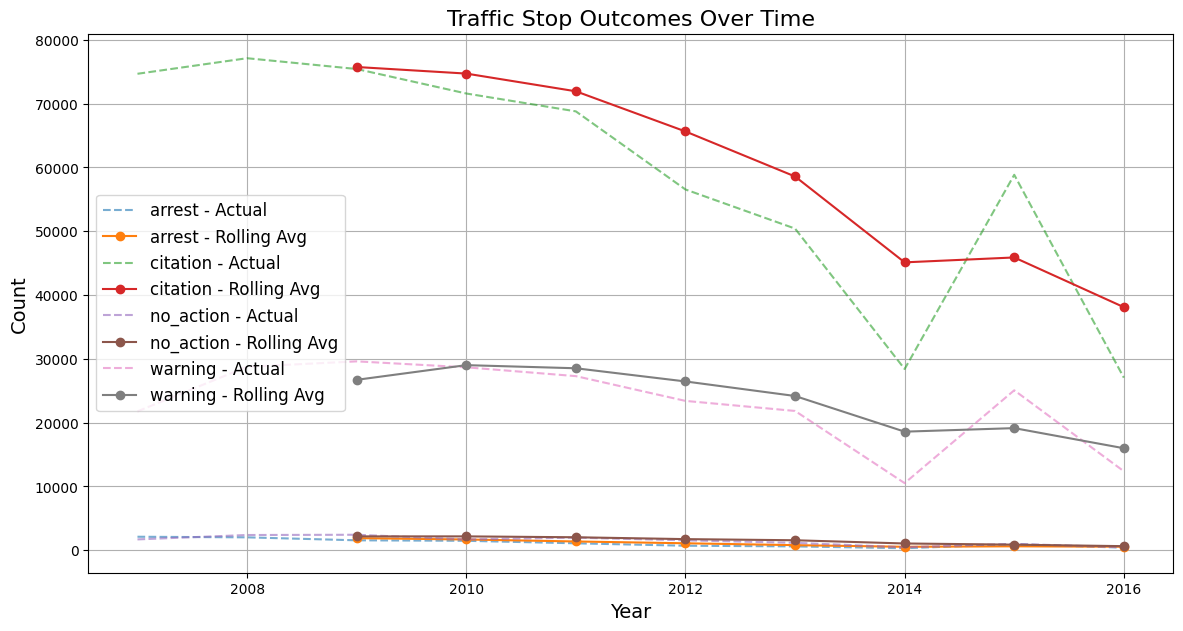

In [ ]:
#@title Visualize Trends with Smoothing

# Plot raw counts with rolling averages
rolling_outcomes = yearly_outcomes.rolling(window=3).mean()
plt.figure(figsize=(14, 7))
for outcome in yearly_outcomes.columns:
    plt.plot(yearly_outcomes.index, yearly_outcomes[outcome], label=f'{outcome} - Actual', linestyle='--', alpha=0.6)
    plt.plot(rolling_outcomes.index, rolling_outcomes[outcome], label=f'{outcome} - Rolling Avg', marker='o')
plt.title('Traffic Stop Outcomes Over Time', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

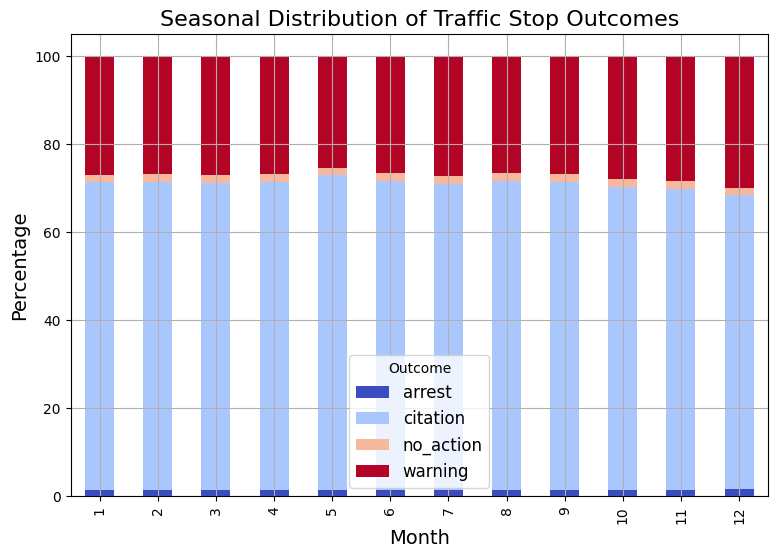

In [ ]:
#@title Seasonal Variations Analysis

# Aggregate data by month across all years
monthly_outcomes = data.groupby(['month', 'outcome']).size().unstack(fill_value=0)

# Normalize
monthly_outcomes_norm = monthly_outcomes.div(monthly_outcomes.sum(axis=1), axis=0) * 100

# Visualize seasonal trends
monthly_outcomes_norm.plot(kind='bar', stacked=True, figsize=(9, 6), colormap='coolwarm')
plt.title('Seasonal Distribution of Traffic Stop Outcomes', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.legend(title='Outcome', fontsize=12)
plt.grid()
plt.show()

## 7.3 Geographic Distribution

In [ ]:
# @title Download OpenStreetMap Data for San Francisco Streets Using a Reliable Source GeoJSON

import osmnx as ox

# Retrieve San Francisco street network
sf_streets = ox.graph_to_gdfs(ox.graph_from_place("San Francisco, California, USA", network_type="drive"))[0]

# Save as GeoJSON if needed
sf_streets.to_file("san_francisco_streets.geojson", driver="GeoJSON")

# Print basic info
print(sf_streets.head())

                  y           x  street_count            highway  ref railway  \
osmid                                                                           
32927563  37.786017 -122.390902             3                NaN  NaN     NaN   
32927591  37.731371 -122.423671             3  motorway_junction   53     NaN   
32927645  37.732706 -122.413261             3  motorway_junction  54B     NaN   
33241803  37.805042 -122.403450             5    traffic_signals  NaN     NaN   
33242031  37.799054 -122.416484             1                NaN  NaN     NaN   

                             geometry  
osmid                                  
32927563   POINT (-122.3909 37.78602)  
32927591  POINT (-122.42367 37.73137)  
32927645  POINT (-122.41326 37.73271)  
33241803  POINT (-122.40345 37.80504)  
33242031  POINT (-122.41648 37.79905)  


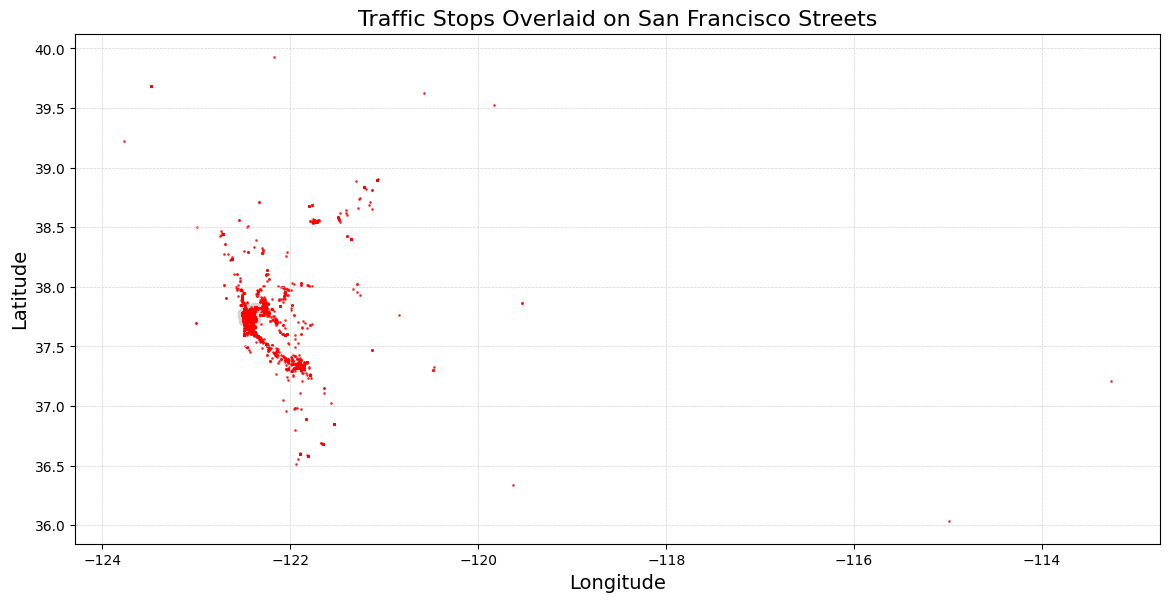

In [ ]:
# @title Overview of Stops
# Convert processed dataframe to GeoDataFrame
geometry = [Point(xy) for xy in zip(data['lng'], data['lat'])]
geo_data = gpd.GeoDataFrame(data, geometry=geometry, crs="EPSG:4326")

# Plot streets and traffic stops
fig, ax = plt.subplots(figsize=(14, 10))
sf_streets.plot(ax=ax, color='lightgrey', linewidth=0.5)
geo_data.plot(ax=ax, color='red', markersize=1, alpha=0.7)
plt.title('Traffic Stops Overlaid on San Francisco Streets', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid(color='lightgrey', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
# @title Processing for Filterinng data to San Francisco
# Get San Francisco administrative boundary
sf_boundary = ox.geocode_to_gdf("San Francisco, California, USA")

# Filter to retain only the largest polygon (main San Francisco area)
sf_boundary = sf_boundary.explode(index_parts=False)  # Split MultiPolygon into individual polygons
sf_boundary['area'] = sf_boundary.geometry.area  # Calculate area for each polygon
sf_boundary = sf_boundary[sf_boundary['area'] == sf_boundary['area'].max()]  # Keep the largest polygon

# Ensure the CRS is compatible with your data
sf_boundary = sf_boundary.to_crs("EPSG:4326")

# Ensure GeoDataFrame CRS matches boundary CRS
geo_data = geo_data.to_crs(sf_boundary.crs)

# Perform spatial join to retain only points within the San Francisco boundary
sf_stops = gpd.sjoin(geo_data, sf_boundary, how="inner", predicate="within")

# Drop columns
sf_stops = sf_stops.drop(columns=['index_right', 'bbox_west', 'bbox_south',
       'bbox_east', 'bbox_north', 'place_id', 'osm_type', 'osm_id',
       'lat_right', 'class', 'type', 'place_rank', 'importance',
       'addresstype', 'name', 'display_name', 'area', 'lon'])

sf_stops = sf_stops.rename(columns={'lat_left': 'lat'})
sf_stops = sf_stops.rename(columns={'lng': 'lon'})

# Reorder columns
sf_stops = sf_stops[['lat', 'lon'] + [col for col in sf_stops.columns if col not in ('lat', 'lon')]]

# Plot traffic stops within San Francisco
sample_size = 80000
sf_stops_sampled = sf_stops.sample(n=sample_size, random_state=42)  # random_state for reproducibility

<ipython-input-34-8b8d4f8b7887>:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sf_boundary['area'] = sf_boundary.geometry.area  # Calculate area for each polygon


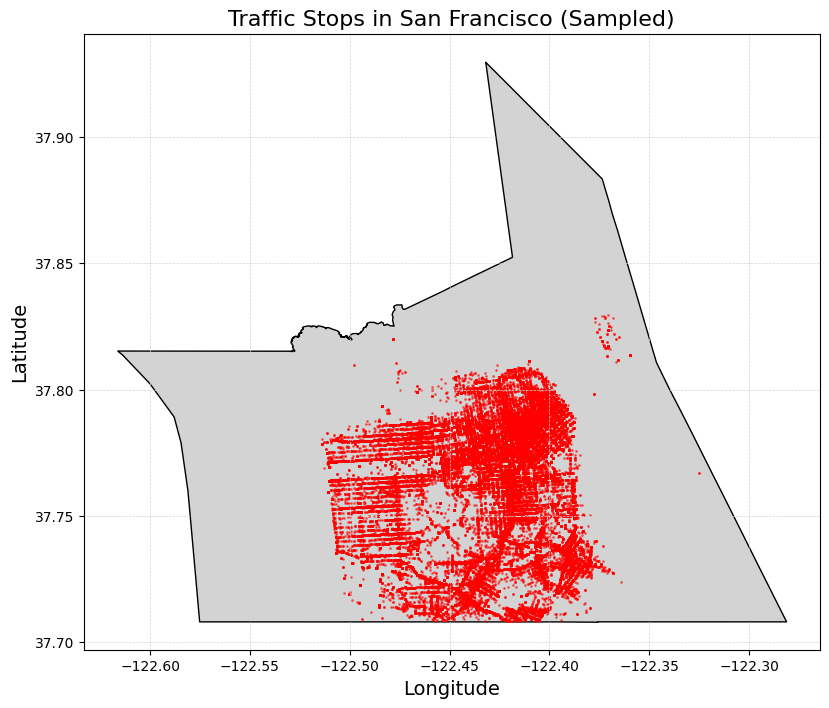

In [ ]:
# @title Filter data to San Francisco

import osmnx as ox
'''
from shapely.geometry import Polygon

# Define a simple bounding box around San Francisco
sf_boundary = gpd.GeoDataFrame({
    'geometry': [Polygon([
        (-123.173825, 37.639830),  # Southwest
        (-122.281780, 37.639830),  # Southeast
        (-122.281780, 37.929824),  # Northeast
        (-123.173825, 37.929824),  # Northwest
        (-123.173825, 37.639830)   # Back to start
    ])]
}, crs="EPSG:4326")

# Plot to verify the boundary
sf_boundary.plot(color='lightgrey', edgecolor='black', figsize=(10, 8))
plt.title("San Francisco Approximate Boundary", fontsize=16)
plt.show()
'''

fig, ax = plt.subplots(figsize=(12, 8))
sf_boundary.plot(ax=ax, color='lightgrey', edgecolor='black')
sf_stops_sampled.plot(ax=ax, color='red', markersize=1, alpha=0.5)
plt.title('Traffic Stops in San Francisco (Sampled)', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid(color='lightgrey', linestyle='--', linewidth=0.5)
plt.show()

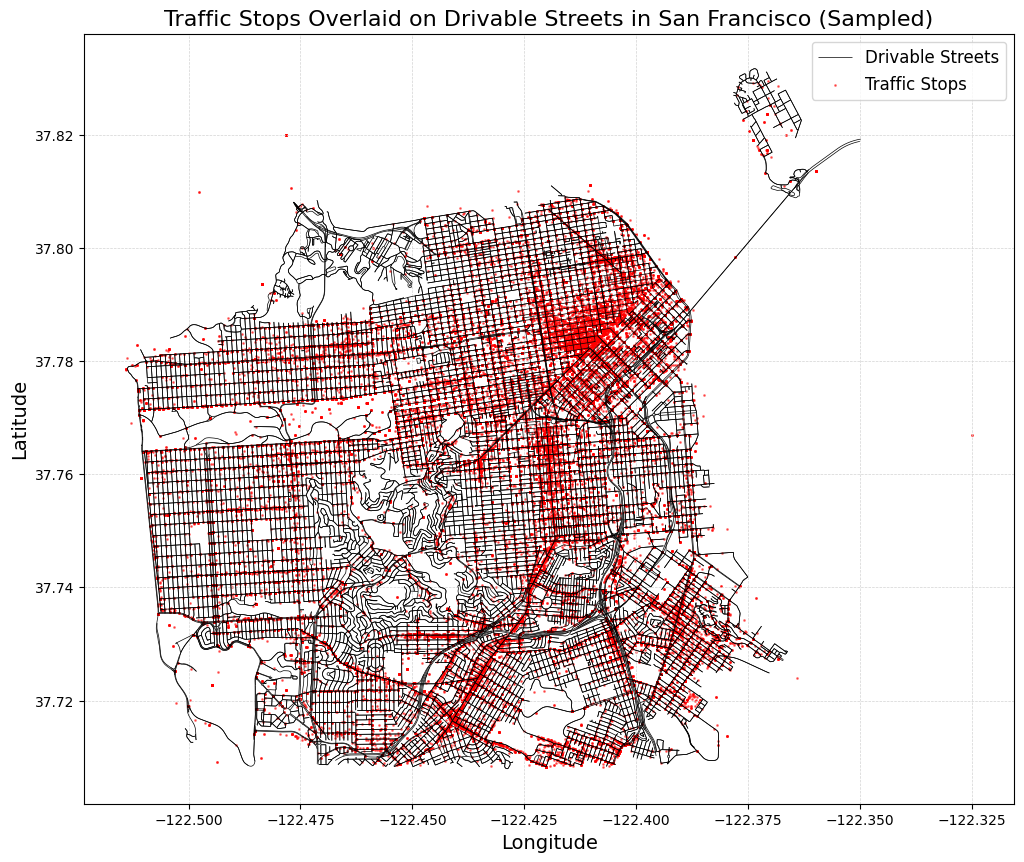

In [ ]:
# @title Spatial Join with Drivable Streets

import osmnx as ox
import matplotlib.pyplot as plt

# Retrieve the drivable street network for San Francisco
sf_drive_network = ox.graph_from_place("San Francisco, California, USA", network_type="drive")

# Convert the network to a GeoDataFrame for plotting
sf_drive_edges = ox.graph_to_gdfs(sf_drive_network, nodes=False, edges=True)

# Ensure CRS compatibility
sf_drive_edges = sf_drive_edges.to_crs("EPSG:4326")
sf_stops = sf_stops.to_crs(sf_drive_edges.crs)

# Plot drivable streets and traffic stops
fig, ax = plt.subplots(figsize=(14, 10))
sf_drive_edges.plot(ax=ax, color='black', linewidth=0.5, label='Drivable Streets')
sf_stops_sampled.plot(ax=ax, color='red', markersize=1, alpha=0.5, label='Traffic Stops')
plt.title("Traffic Stops Overlaid on Drivable Streets in San Francisco (Sampled)", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
plt.legend(fontsize=12)
plt.grid(color="lightgrey", linestyle="--", linewidth=0.5)
plt.show()

In [ ]:
sf_drive_edges.plot(ax=ax, color='black', linewidth=0.5, label='Drivable Streets')

<Axes: title={'center': 'Traffic Stops Overlaid on Drivable Streets in San Francisco (Sampled)'}, xlabel='Longitude', ylabel='Latitude'>

<ipython-input-38-16812f0e4958>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(stop_types))


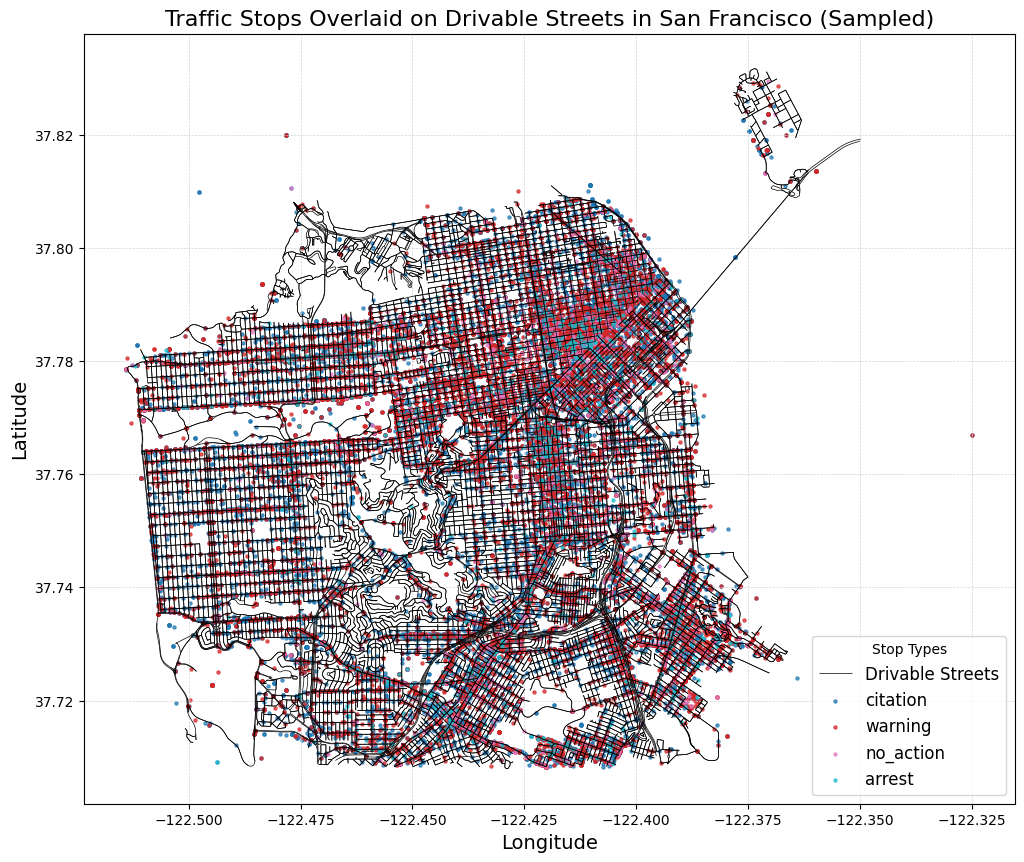

In [ ]:
# Ensure CRS compatibility
sf_drive_edges = sf_drive_edges.to_crs("EPSG:4326")
geo_data_sampled = sf_stops_sampled.to_crs(sf_drive_edges.crs)

# Plot drivable streets and traffic stops

# Get the unique outcomes (or replace 'outcome' with another column of interest)
stop_types = geo_data_sampled['outcome'].unique()

# Define a colormap
colors = plt.cm.get_cmap('tab10', len(stop_types))

# Create a figure
fig, ax = plt.subplots(figsize=(14, 10))

# Plot drivable streets
sf_drive_edges.plot(ax=ax, color='black', linewidth=0.5, label='Drivable Streets')

# Plot different types of stops
for i, stop_type in enumerate(stop_types):
    subset = geo_data_sampled[geo_data_sampled['outcome'] == stop_type]
    subset.plot(
        ax=ax,
        color=colors(i),
        markersize=5,
        alpha=0.7,
        label=stop_type
    )

# Add title, labels, legend, and grid
plt.title("Traffic Stops Overlaid on Drivable Streets in San Francisco (Sampled)", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
plt.legend(title="Stop Types", fontsize=12)
plt.grid(color="lightgrey", linestyle="--", linewidth=0.5)
plt.show()

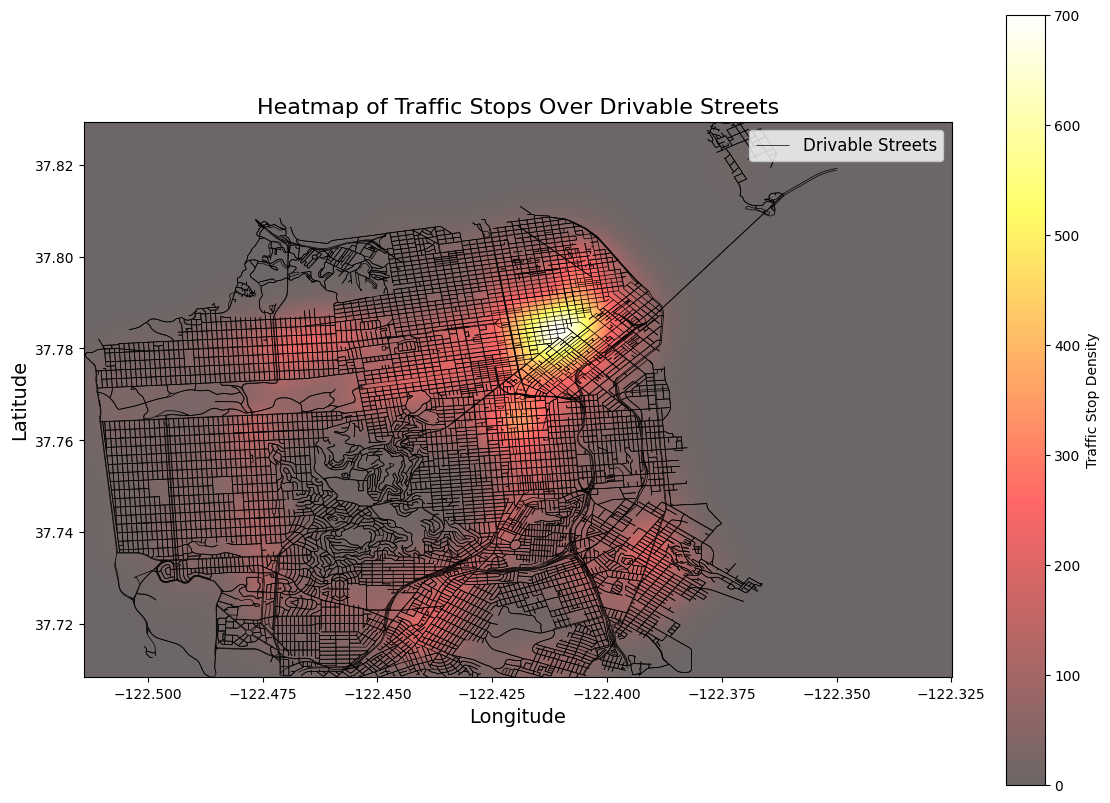

In [ ]:
# @title kernel density estimation (KDE) heatmap
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

# Extract coordinates from traffic stops
x = geo_data_sampled.geometry.x
y = geo_data_sampled.geometry.y

# Perform kernel density estimation
kde = gaussian_kde([x, y])
xi, yi = np.meshgrid(
    np.linspace(x.min(), x.max(), 500),
    np.linspace(y.min(), y.max(), 500)
)
zi = kde(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)

# Plot drivable streets
fig, ax = plt.subplots(figsize=(14, 10))
sf_drive_edges.plot(ax=ax, color='black', linewidth=0.5, label='Drivable Streets')

# Overlay heatmap
heatmap = ax.imshow(
    zi,
    extent=[x.min(), x.max(), y.min(), y.max()],
    origin='lower',
    cmap='hot',
    alpha=0.6
)

# Add colorbar and legend
plt.colorbar(heatmap, ax=ax, label='Traffic Stop Density')
plt.title("Heatmap of Traffic Stops Over Drivable Streets", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
plt.legend(fontsize=12)
plt.show()

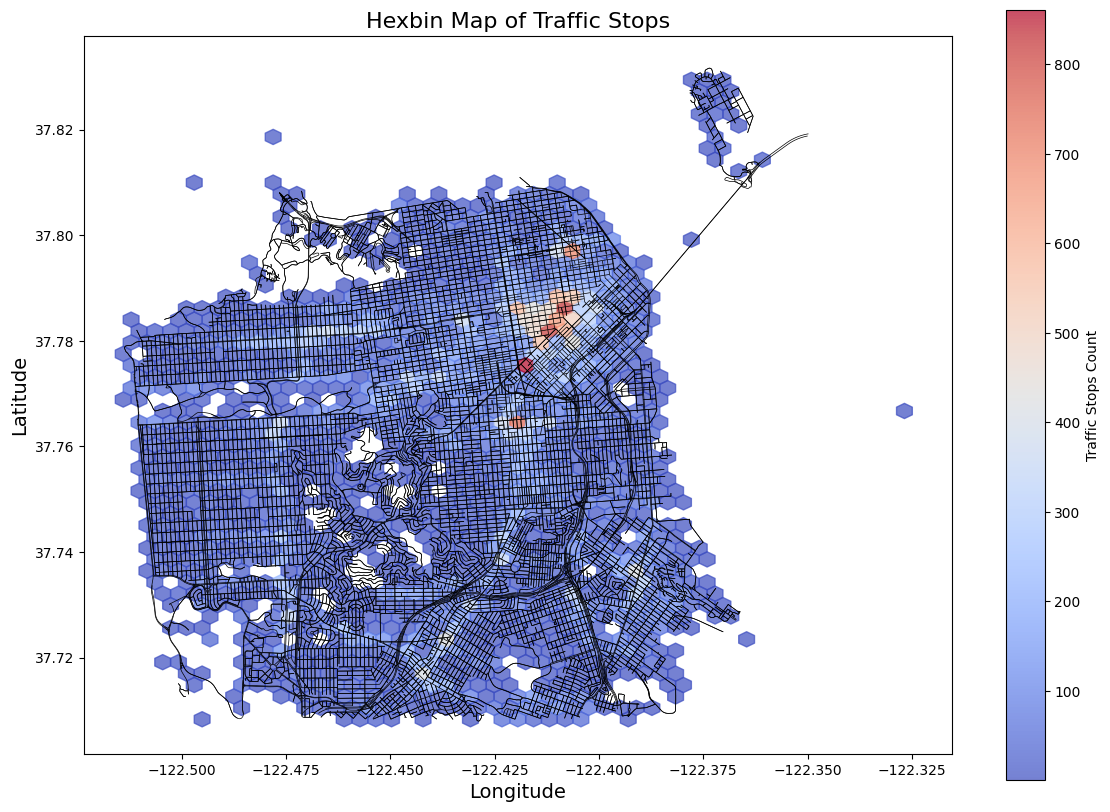

In [ ]:
# @title Hexbin Map for Spatial Aggregation

# Create hexbin aggregation
fig, ax = plt.subplots(figsize=(14, 10))
hb = ax.hexbin(
    x,
    y,
    gridsize=50,
    cmap='coolwarm',
    alpha=0.7,
    mincnt=1
)

# Overlay drivable streets
sf_drive_edges.plot(ax=ax, color='black', linewidth=0.5)

# Add colorbar and labels
plt.colorbar(hb, ax=ax, label='Traffic Stops Count')
plt.title("Hexbin Map of Traffic Stops", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
plt.show()

<ipython-input-41-5a329b40ff73>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', demographics.shape[0])


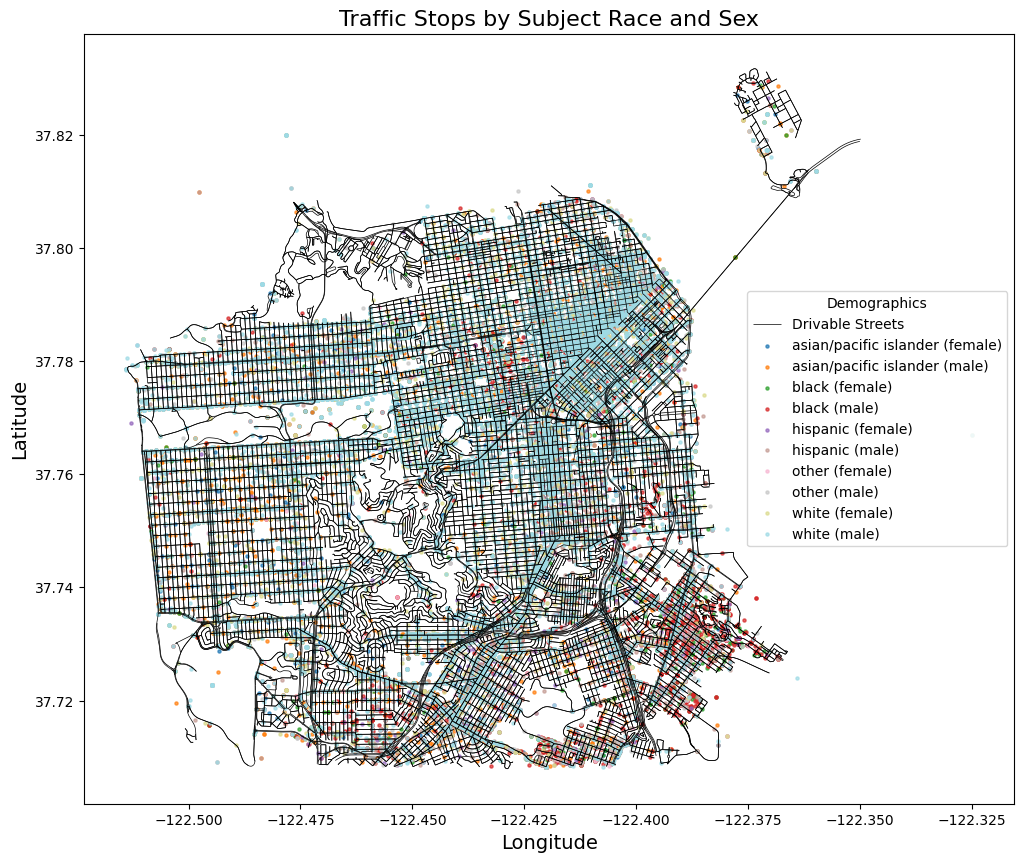

In [ ]:
# @title Demographic Analysis: Stops by Race and Sex

# Unique combinations of race and sex
demographics = geo_data_sampled.groupby(['subject_race', 'subject_sex']).size().reset_index(name='count')

# Create a color map
colors = plt.cm.get_cmap('tab20', demographics.shape[0])

# Plot the drivable streets
fig, ax = plt.subplots(figsize=(14, 10))
sf_drive_edges.plot(ax=ax, color='black', linewidth=0.5, label='Drivable Streets')

# Plot traffic stops grouped by race and sex
for i, (race, sex) in enumerate(demographics[['subject_race', 'subject_sex']].values):
    subset = geo_data_sampled[(geo_data_sampled['subject_race'] == race) & (geo_data_sampled['subject_sex'] == sex)]
    subset.plot(ax=ax, color=colors(i), markersize=5, alpha=0.7, label=f'{race} ({sex})')

# Add legend and title
plt.title("Traffic Stops by Subject Race and Sex", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
plt.legend(title="Demographics", fontsize=10)
plt.show()

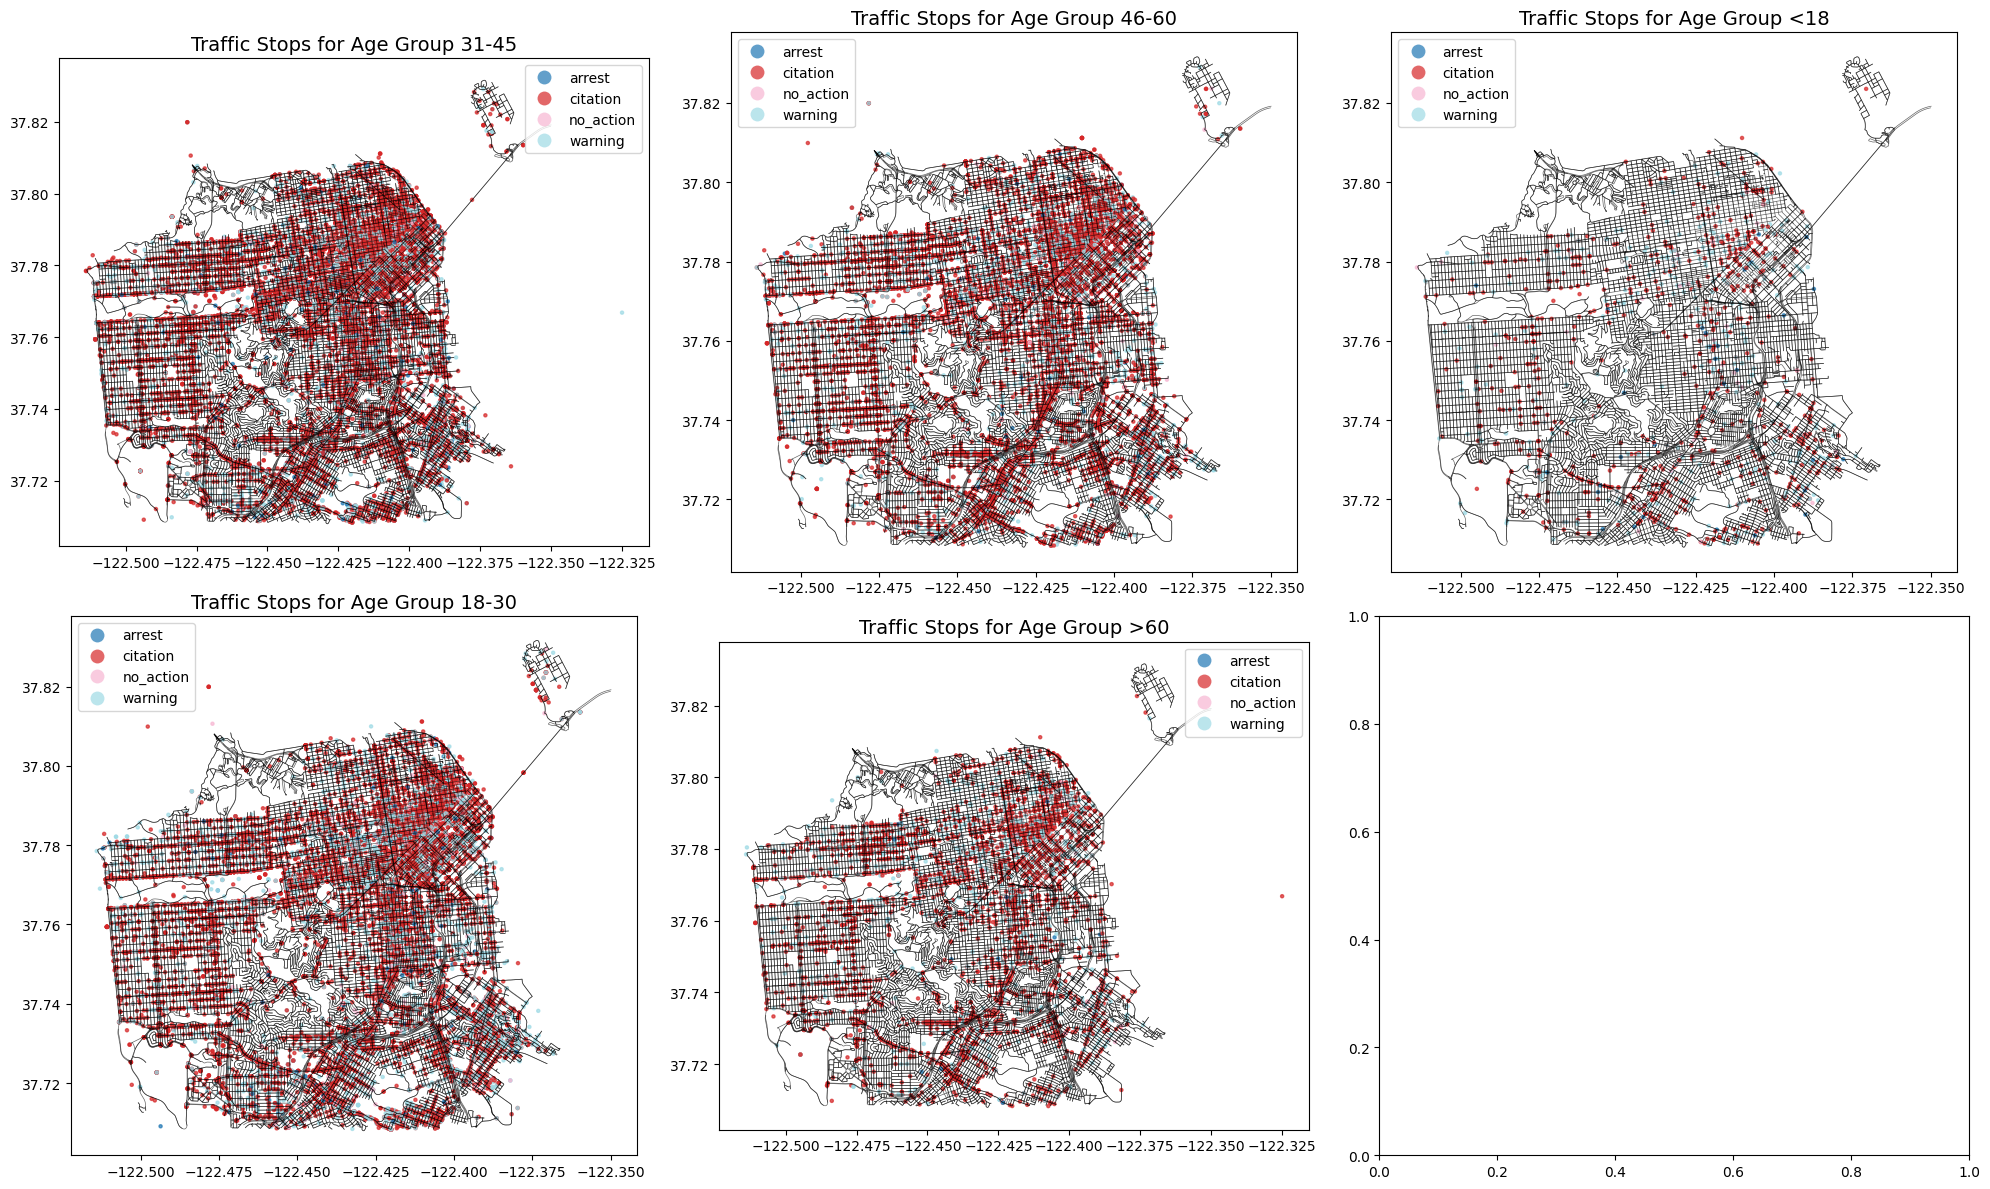

In [ ]:
# @title Spatial Heatmap by Outcome and Age Group

# Define age groups
geo_data_sampled['age_group'] = pd.cut(
    geo_data_sampled['subject_age'],
    bins=[0, 18, 30, 45, 60, 100],
    labels=['<18', '18-30', '31-45', '46-60', '>60']
)

# Create a grid for plotting outcomes by age group
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

# Plot each age group
for i, age_group in enumerate(geo_data_sampled['age_group'].unique()):
    if pd.isna(age_group):
        continue
    ax = axes[i]
    sf_drive_edges.plot(ax=ax, color='black', linewidth=0.5, alpha=0.6)
    subset = geo_data_sampled[geo_data_sampled['age_group'] == age_group]
    subset.plot(ax=ax, column='outcome', cmap='tab20', markersize=5, legend=True, alpha=0.7)
    ax.set_title(f"Traffic Stops for Age Group {age_group}", fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()

# 8 Feature Importance, SHAP Dependence

In [ ]:
# @title Data Processing
data = df.drop(columns = ["raw_row_number", "location", "arrest_made", "citation_issued", "warning_issued", "search_basis", 'type','raw_result_of_contact_description','raw_search_vehicle_description'])
# drop those missing time or age as those are important features we are going to model on
data = data[~((data["time"].isna()) | (data["subject_age"].isna()))]

# Get year and month from data; get hour from time, and drop original columns
data['year'] = pd.to_datetime(data['date'], format='%Y-%m-%d').dt.year.astype(object)
data['month'] = pd.to_datetime(data['date'], format='%Y-%m-%d').dt.month.astype(object)
data['hour'] = pd.to_datetime(data['time'], format='%H:%M:%S').dt.hour.astype(object)
data = data.drop(columns=['date', 'time'])

# According to definition, update NaNs in contraband_found according to search_conducted
data['contraband_found'] = data.apply(
    lambda row: "no_search" if pd.isna(row['contraband_found']) and row['search_conducted'] == False else row['contraband_found'],
    axis=1
)
# delete this since contraband_found already covers the info
data = data.drop(columns = ['search_conducted', "search_vehicle"])

# For columns reason_for_stop, messy categories has below 200 instances. So we merge them into Other
reason_counts = data['reason_for_stop'].value_counts()
data['reason_for_stop'] = data['reason_for_stop'].replace(reason_counts[reason_counts <= 200].index, "Other")

# change NaN in outcome to no_action
data['outcome'] = data['outcome'].fillna('no_action')

# change NaN in district to no_record
data['district'] = data['district'].fillna('no_record')

# change NaN in reason_for_stop to no_record
data['reason_for_stop'] = data['reason_for_stop'].fillna('no_record')

# Drop rows with NaN values in either 'lat' or 'lng'
data = data.dropna(subset=['lat', 'lng'])

data = data.rename(columns={'lng': 'lon'})

data.head()

lat         lon district  subject_age            subject_race  \
33159  37.751445 -122.389574        C         56.0                   white   
33160  37.792563 -122.390973        B         32.0                   white   
33161  37.761562 -122.480251        I         57.0  asian/pacific islander   
33162  37.798712 -122.407910        A         31.0                hispanic   
33163  37.777182 -122.407335        J         37.0                hispanic   

      subject_sex   outcome contraband_found  \
33159        male  citation        no_search   
33160        male  citation        no_search   
33161      female  citation        no_search   
33162        male   warning        no_search   
33163      female  citation        no_search   

                                 reason_for_stop  year month hour  
33159  Mechanical or Non-Moving Violation (V.C.)  2007     1   10  
33160                           Moving Violation  2007     1   10  
33161                           Moving Violation  2007     1   10  
33162                           Moving Violation  2007     1   10  
33163                           Moving Violation  2007     1   10

In [ ]:
# Encode categorical variables
categorical_cols = ['district', 'subject_race', 'subject_sex', 'outcome', 'contraband_found', 'reason_for_stop']
label_encoders = {col: LabelEncoder() for col in categorical_cols}

# Ensure all categorical columns are numeric
for col in categorical_cols:
    data[col] = data[col].astype(str)  # Convert to strings to ensure uniformity
    data[col] = label_encoders[col].fit_transform(data[col])

# Drop columns with non-numeric data that are irrelevant or unnecessary
features = data.drop(columns=['outcome', 'lat', 'lon'])
target = data['outcome']

# Ensure all remaining columns are numeric
features = features.apply(pd.to_numeric, errors='coerce')

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

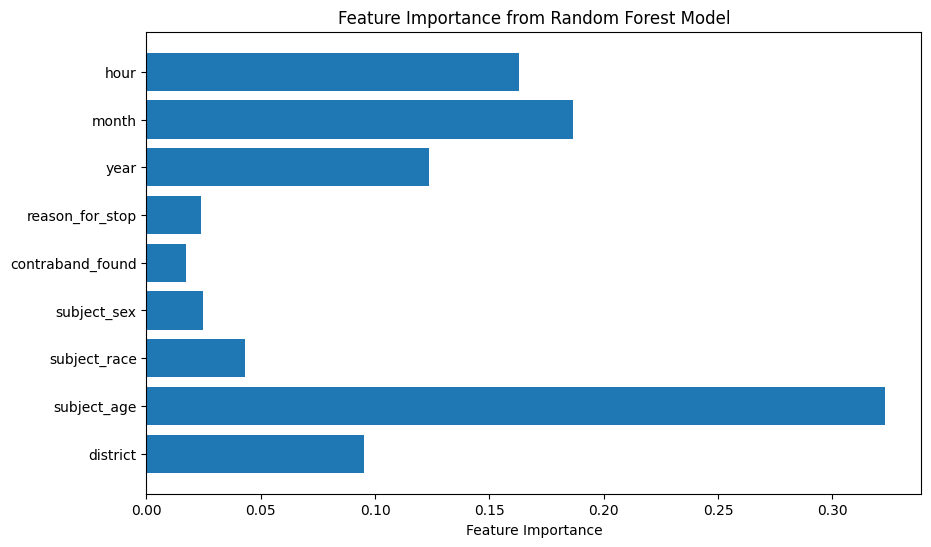

In [ ]:
# @title Random Forest Feature Importance
from sklearn.preprocessing import LabelEncoder

# Fit the Random Forest model
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
rf_model.fit(X_train, y_train)

# Feature Importance Analysis
feature_importances = rf_model.feature_importances_
feature_names = features.columns

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances, align='center')
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest Model')
plt.show()

In [ ]:
# @title SHAP Dependence for Top Features
import shap
# Step 1: Calculate SHAP values
explainer = shap.Explainer(rf_model, X_train)  # Train explainer on the model and training data
shap_values = explainer(X_test)  # Calculate SHAP values for test data

# Step 2: SHAP Summary Plot (Feature Importance Overview)
shap.summary_plot(shap_values, X_test)  # Standard summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")  # Bar plot for feature ranking

# Step 3: Visualize Relationships for Top Features
# Identify top 5 features by mean absolute SHAP values
shap_importance = np.abs(shap_values.values).mean(axis=0)
top_features = X_test.columns[np.argsort(-shap_importance)[:5]]  # Top 5 feature names

# Step 4: SHAP Dependence Plots for Top Features
for feature in top_features:
    shap.dependence_plot(feature, shap_values.values, X_test, interaction_index=None)  # No interaction

In [ ]:
# SHAP Dependence Plot with Interaction (e.g., Age & Race)
shap.dependence_plot('subject_age', shap_values.values, X_test, interaction_index='subject_race')

# SHAP Dependence Plot with Interaction (e.g., District & Hour)
shap.dependence_plot('District', shap_values.values, X_test, interaction_index='hour')

In [ ]:
# Focus on specific features
shap.dependence_plot('reason_for_stop', shap_values.values, X_test)
shap.dependence_plot('district', shap_values.values, X_test)

In [ ]:
# @title Feature Pair Analysis
sns.pairplot(data[['subject_age', 'subject_race', 'subject_sex', 'outcome']])
plt.show()

In [ ]:
# @title Partial Dependence Plot (PDP)
# PDPs help visualize the marginal effect of a feature on the predicted outcome.
# For the top 3 important features, create PDPs:
from sklearn.inspection import PartialDependenceDisplay

top_features = feature_names[np.argsort(feature_importances)[-3:]]
PartialDependenceDisplay.from_estimator(rf_model, X_train, top_features, kind="both")
plt.show()

# 9 Unsupervised Learning: Dimensionality Reduction + Clustering

In [ ]:
weighted_features = features * feature_importances
weighted_features = features
sample_size = 8000
weighted_features_scaled = weighted_features.sample(n=sample_size, random_state=42)
weighted_features_scaled.head()

district  subject_age  subject_race  subject_sex  contraband_found  \
172679         3         34.0             2            1                 0   
575673         3         37.0             1            1                 1   
880630         7         22.0             2            1                 0   
455265         3         37.0             2            0                 2   
79429          4         49.0             4            0                 2   

        reason_for_stop  year  month  hour  
172679                5  2008      4    16  
575673                8  2012      2    12  
880630                5  2016      6    19  
455265                4  2010     11    20  
79429                 4  2007      6    12

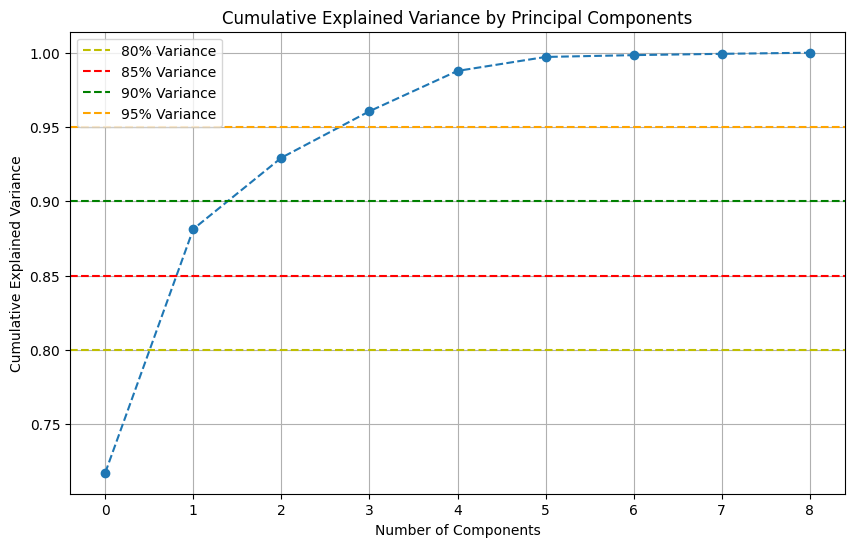

Number of PCs used: 3


In [ ]:
# @title Dimensionality Reduction: PCA
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Fit PCA on standardized data
pca = PCA()
principal_components = pca.fit_transform(weighted_features_scaled)

# Plot cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--')
plt.axhline(0.80, color='y', linestyle='--', label='80% Variance')
plt.axhline(0.85, color='r', linestyle='--', label='85% Variance')
plt.axhline(0.90, color='g', linestyle='--', label='90% Variance')
plt.axhline(0.95, color='orange', linestyle='--', label='95% Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid()
plt.show()

# Determine the number of PCs that explain 95% of the variance
num_pcs = np.argmax(cumulative_variance >= 0.95) + 1

# Use reduced PCs
X_reduced = principal_components[:, :6]
print(f"Number of PCs used: {num_pcs-1}")

In [ ]:
# Step 4: Reduce data using selected number of PCs
X_reduced = principal_components[:, :num_pcs]

# Optional: Print the shape of the reduced data
print(f"Reduced data shape: {X_reduced.shape}")

Reduced data shape: (8000, 4)


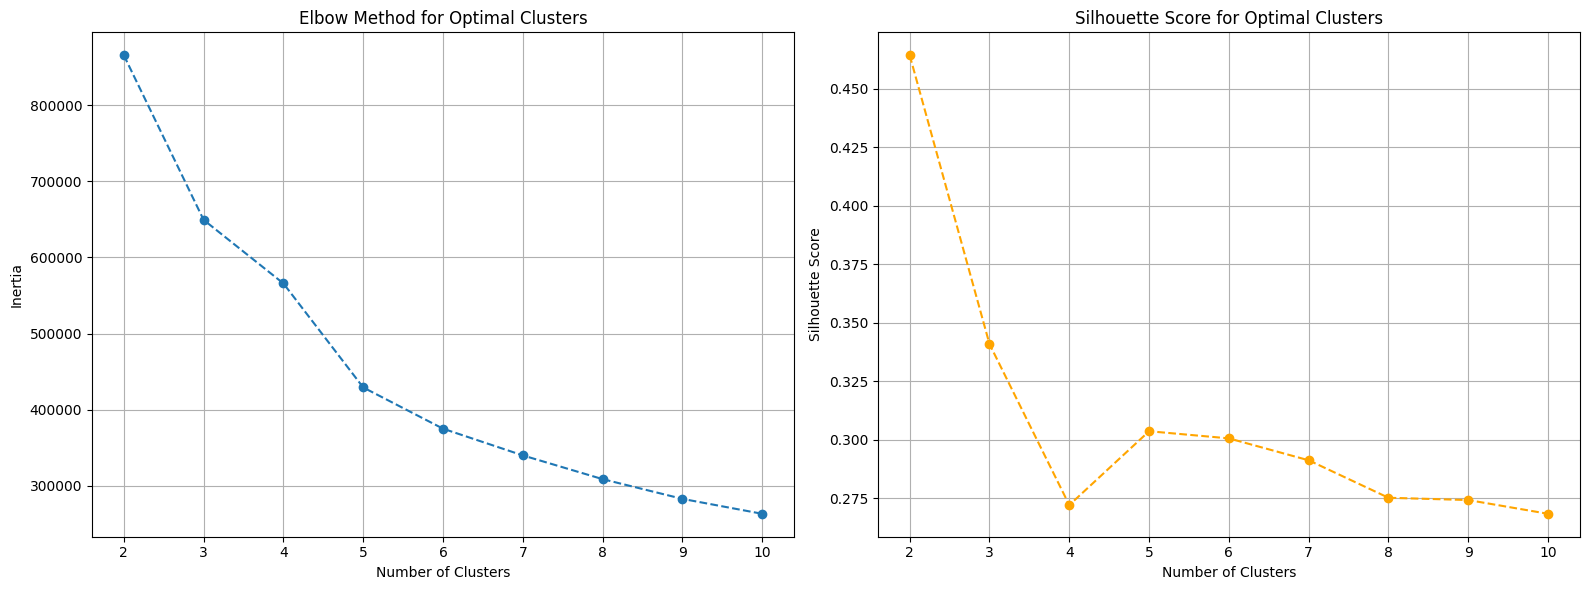

In [ ]:
# @title Determine the optimal number of clusters

pca = PCA(n_components=3)
X_reduced = pca.fit_transform(weighted_features_scaled)

# Determine the optimal number of clusters
inertias = []
silhouette_scores = []
k_values = range(2, 11)  # Test cluster sizes from 2 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_reduced)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_reduced, kmeans.labels_))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Create a 1x2 grid of subplots

# Elbow Method Plot
axes[0].plot(k_values, inertias, marker='o', linestyle='--')
axes[0].set_title('Elbow Method for Optimal Clusters')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Inertia')
axes[0].grid()

# Silhouette Score Plot
axes[1].plot(k_values, silhouette_scores, marker='o', linestyle='--', color='orange')
axes[1].set_title('Silhouette Score for Optimal Clusters')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Silhouette Score')
axes[1].grid()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

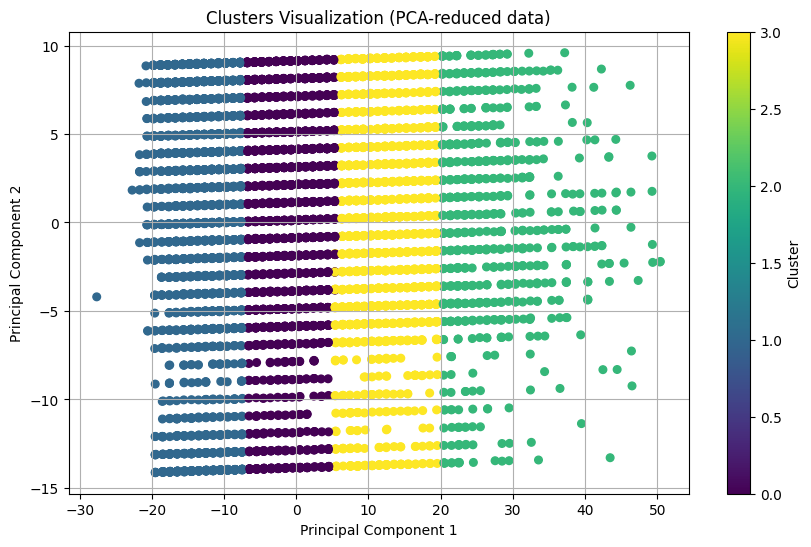

In [ ]:
# @title Perform K-Means clustering with 4 clusters
optimal_k = 4  # Based on prior analysis
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_reduced)
weighted_features_scaled['cluster'] = kmeans_labels
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeans_labels, cmap='viridis', s=30)
plt.title('Clusters Visualization (PCA-reduced data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()

In [ ]:
# Add the "outcome" column from the `target` DataFrame to `weighted_features_scaled`
weighted_features_scaled['outcome'] = target
weighted_features_scaled.head()

district  subject_age  subject_race  subject_sex  contraband_found  \
172679         3         34.0             2            1                 0   
575673         3         37.0             1            1                 1   
880630         7         22.0             2            1                 0   
455265         3         37.0             2            0                 2   
79429          4         49.0             4            0                 2   

        reason_for_stop  year  month  hour  cluster  outcome  
172679                5  2008      4    16        0        2  
575673                8  2012      2    12        0        0  
880630                5  2016      6    19        1        3  
455265                4  2010     11    20        0        1  
79429                 4  2007      6    12        3        1

In [ ]:
# Group data by clusters and compute summary statistics
cluster_summary = weighted_features_scaled.groupby('cluster').mean()
print("Cluster Summary (Mean):")
cluster_summary

Cluster Summary (Mean):


district  subject_age  subject_race  subject_sex  contraband_found  \
cluster                                                                       
0        4.314321    36.399261      2.498153     0.694296          1.899056   
1        4.428902    24.641204      2.328373     0.691468          1.826389   
2        4.808376    64.704315      2.527919     0.706853          1.963198   
3        4.435180    49.767561      2.398629     0.708738          1.924043   

         reason_for_stop         year     month       hour   outcome  
cluster                                                               
0               4.631924  2010.812064  5.878539  14.034058  1.508412  
1               4.562169  2010.719577  6.092923  14.000331  1.589286  
2               4.705584  2011.120558  5.936548  13.623096  1.527919  
3               4.643632  2010.928612  6.031982  13.493432  1.482581

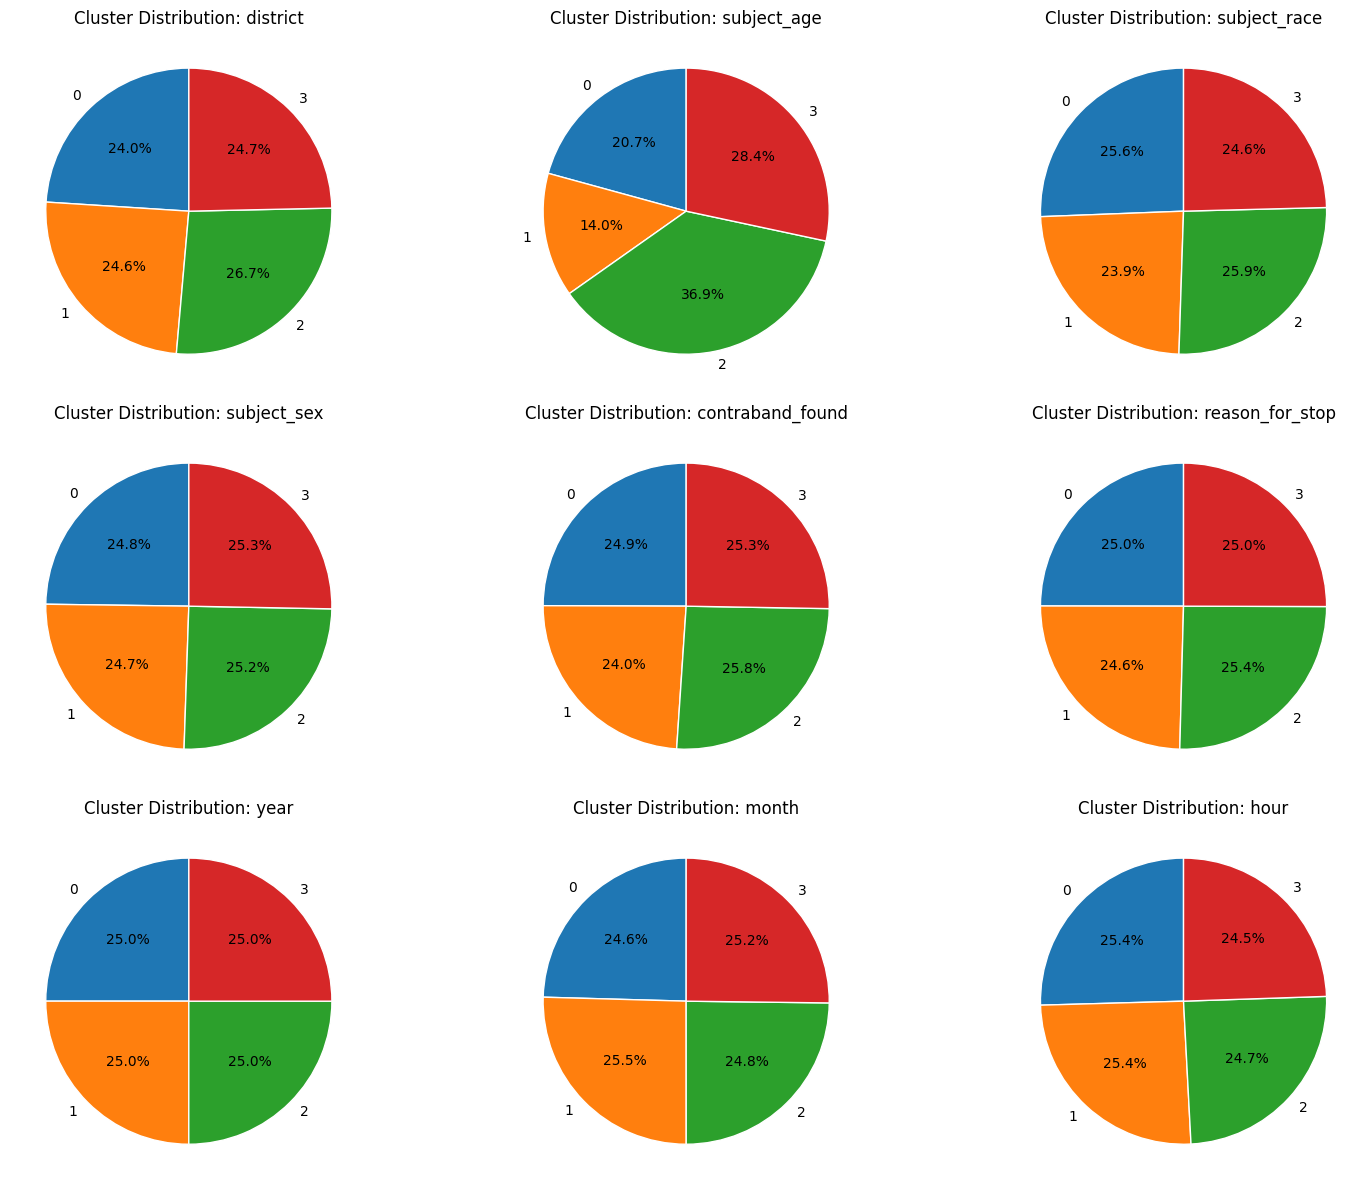

In [ ]:
# Features to visualize in ring plots (numerical features in the cluster summary)
features = weighted_features_scaled.columns[:-1]  # Exclude the cluster column

# Group data by clusters and compute mean for each feature
cluster_summary = weighted_features_scaled.groupby('cluster').mean()

# Subplots for ring plots
fig, axes = plt.subplots(3,3, figsize=(16, 12))
axes = axes.flatten()

for i, feature in enumerate(features):
    data = cluster_summary[feature]
    axes[i].pie(
        data, labels=data.index, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'white'}
    )
    axes[i].set_title(f"Cluster Distribution: {feature}")

# Hide any unused subplots
for j in range(len(features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

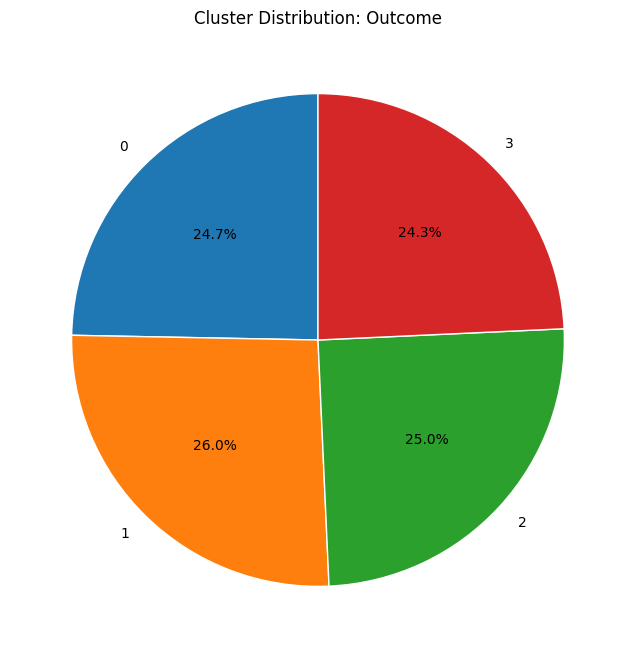

In [ ]:
# Group the "outcome" column by clusters and compute the mean
outcome_summary = weighted_features_scaled.groupby('cluster')['outcome'].mean()

# Plot a ring (pie) plot for the "outcome" column
plt.figure(figsize=(8, 8))
plt.pie(
    outcome_summary, labels=outcome_summary.index, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'white'}
)
plt.title("Cluster Distribution: Outcome")
plt.show()

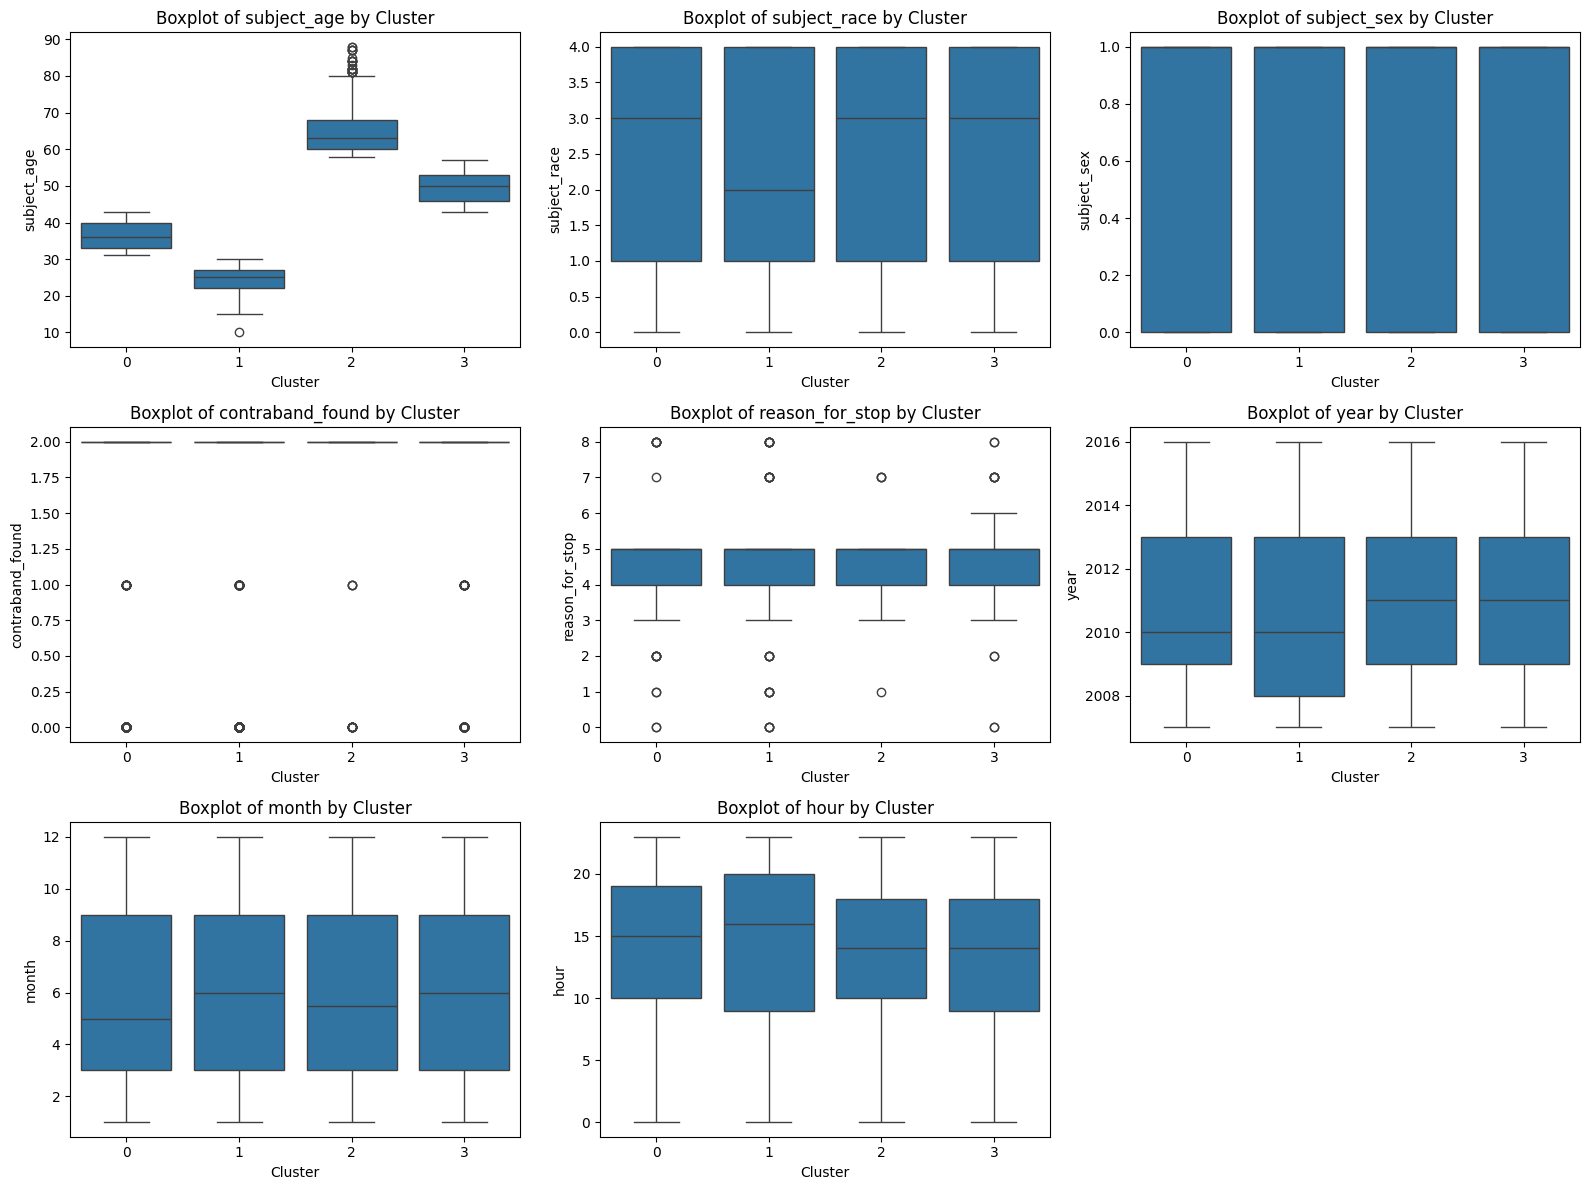

In [ ]:
numerical_features = ['subject_age', 'subject_race', 'subject_sex',
                      'contraband_found', 'reason_for_stop', 'year',
                      'month', 'hour']

# Create a 3x3 grid for boxplots
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.boxplot(x='cluster', y=feature, data=weighted_features_scaled, ax=axes[i])
    axes[i].set_title(f"Boxplot of {feature} by Cluster")
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(feature)

# Hide any unused subplots (if there are less than 9 features)
for j in range(len(numerical_features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()